In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import pprint

import matplotlib.pyplot as plt
import powerlaw
from math import ceil
from bokeh.io import output_file, save
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.palettes import d3
from bokeh.models import WheelZoomTool

from IPython.display import FileLink
from pandarallel import pandarallel

# Increase width to be able to better read the reviews when displaying dataframe
pd.options.display.max_colwidth = 100

In [2]:
pandarallel.initialize(nb_workers=3)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Constant and basic function definition

In [3]:
# Constant definitions
REVIEW_FILE = "Grocery_and_Gourmet_Food.json"
REVIEW_PICKLE = "reviews"
META_FILE = "meta_Grocery_and_Gourmet_Food.json"
META_PICKLE = "meta"
DATA_LOCATION = "data/"
PICKLE_LOCATION = "processed-data/"
PLOTS_LOCATION = "milestone-2-plots/"

In [4]:
def load_pickle(pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'rb') as file:
        print(f'loading pickle for {pickle_name}...')
        return pickle.load(file)

In [5]:
def save_pickle(result, pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'wb') as file:
        print(f'saving pickle for {pickle_name}...')
        pickle.dump(result, file)

In [6]:
def read_file(file):
    if file == REVIEW_FILE:
        pickle_name = REVIEW_PICKLE
    elif file == META_FILE:
        pickle_name = META_PICKLE
    else:
        pickle_name = file
    
    try:
        return load_pickle(pickle_name)
    except (FileNotFoundError, EOFError) as e:
        file_df = pd.read_json(DATA_LOCATION+file, lines=True)
        save_pickle(file_df, pickle_name)
        return file_df

## 1. Presentation of the datasets and pre-processing

First we load the data and see what it looks like, in order to sanitize it.

We have 2 data files, one containing Amazon 'Grocery and Gourmet Food' reviews, the other one containing meta information about the products.

In [7]:
reviews = read_file(REVIEW_FILE)
meta = read_file(META_FILE)
print("Meta dataset:")
display(meta.head())
print("\nReviews dataset:")
reviews

loading pickle for reviews...
loading pickle for meta...
Meta dataset:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Statements regarding dietary supplements have not been...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX598, B001LM42GY, B001LM5TDY]",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]","[Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5QE, 0804189986, B00Q4OL2F8, 1101902663, B019PDEUU8,...","[https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...",[Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN



Reviews dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,1370304000,NaN,NaN,NaN
1,4,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,1400803200,NaN,NaN,NaN
2,4,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,1397606400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5074155,5,True,"10 4, 2018",AGOPF2VTEOP57,B01HJHSVG6,Bob,"Love this product, very fresh, complete full flavor, will buy again",Exceclent product,1538611200,NaN,NaN,{'Size:': ' 2.29 oz'}
5074156,3,True,"10 3, 2018",A5X5TI4JCH9CN,B01HJHSVG6,Jacqueline Schafer,Good taste but small quantity for the expensive price. Organic vanilla is usually not so expensi...,Good taste but small quantity for the price used 3/4 of this for 1 recipe,1538524800,NaN,NaN,{'Size:': ' 2.29 oz'}
5074157,4,True,"10 2, 2018",A1WMQQLC3TVAFI,B01HJHSVG6,Motionjunkie,"Unlike some of the bad reviews regarding aroma, when I opened the glass jar, I got a good whiff ...",See Comments below,1538438400,NaN,NaN,{'Size:': ' 2.29 oz'}
5074158,5,True,"09 30, 2018",ALVP6JZRTEDY6,B01HJHSVG6,Marissa,I absolutely love this vanilla bean paste. I had been using vanilla extract for my dessert and b...,Love!!,1538265600,NaN,NaN,{'Size:': ' 2.29 oz'}


We have 5'064'160 reviews and these reviews have 12 attributes. Here is [an example](https://www.amazon.com/gp/customer-reviews/R3OL49W8SWC4EW/ref=cm_cr_arp_d_rvw_ttl?ie=UTF8&ASIN=B0000D916Y) of an Amazon review to illustrate, coming from [this product](https://www.amazon.com/Davids-Cookies-Christmas-Corporate-Certified/dp/B0000D916Y/ref=cm_cr_arp_d_product_top?ie=UTF8).

<img src="misc/amazon-review-example.png">

First let's try to find this review.

In [8]:
reviews_example = reviews[reviews["summary"] == "Not your average tin of cookies!"]
reviews_example

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D9169,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,NaN


Weird, these two reviews look like they are almost the same, but we'll get back to it later. Let's first understand the columns. Using this review: (and image to help comparing)

<img src="misc/amazon-review-example.png">

In [9]:
reviews_example[reviews_example["style"].notnull()]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"


`overall`: the number of stars\
`verified`: tells us if the purchase has been verified, not the case here\
`reviewTime`: Time of the review (day)\
`reviewerID`: Id of the reviewer\
`asin`: Id of the reviewed product (here the cookies)\
`reviewerName`: The name of the reviewer\
`reviewText`: The content of the review\
`summary`: The small sentence to summarize the review (the bold text on the image)\
`unixReviewTime`: Time of the review in unix time\
`vote`: The number of "Helpful" a review has received, here it has received 0. So the value is NaN, they are in essence upvotes.\
`image`: You can link an image in your review on Amazon, here there is none\
`style`: The greyish link below the date, right below the date. It is in fact a link to buy this product: 12 cookies and chocolate chunk flavor

Here you can see an example of a verified review, with 6 upvotes:

<img src="misc/amazon-review-example-upvote.png">

Now let's look at bit closer at why we have two different reviews that look like they are the same.

In [10]:
# Show values that differ in the two reviews
reviews_example.loc[:, reviews_example.values[0] != reviews_example.values[1]]

,asin,vote,image,style
7935,B0000D916Y,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,B0000D9169,NaN,NaN,NaN


So one of them has `style` while the other one doesn't and they are apparently not about the same product. This sounds weird, why would a person post the exact same comment for two different products?

Let's take a closer look at these two products

In [11]:
asins_example = reviews_example['asin'].values
product1 = meta[meta["asin"] == asins_example[0]]
product1

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
402,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
4099,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN


Two rows again, how weird! Let's look at how they differ:

In [12]:
product1.loc[:, product1.values[0] != product1.values[1]]

,price,date,feature,similar_item,tech1,fit
402,NaN,NaN,NaN,NaN,NaN,NaN
4099,NaN,NaN,NaN,NaN,NaN,NaN


This time they are exactly the same, that's interesting to note. We could safely remove one of them.

Let's look at the second product:

In [13]:
product2 = meta[meta["asin"] == asins_example[1]]
product2

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
435,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN
4132,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


In [14]:
product2.loc[:, product2.values[0] != product2.values[1]]

,description,date,feature,similar_item,tech1,fit
435,NaN,NaN,NaN,NaN,NaN,NaN
4132,NaN,NaN,NaN,NaN,NaN,NaN


Again!

But how are these two products different?

In [15]:
two_products = pd.DataFrame([product1.values[0], product2.values[0]], columns=product1.columns)
two_products.loc[:, two_products.values[0] != two_products.values[1]]

,description,title,rank,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...","299,472inGroceryGourmetFood(",NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
1,NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...","29,374inGroceryGourmetFood(",$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


Let's look at the title more closely:

In [16]:
print(two_products.values[0][2])
print(two_products.values[1][2])

David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb.
David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2lb


In fact we think this is due to Amazon products having different 'categories', so that one of them represents the product and the other one would represent the version of the product that the customer bought. Thus why the review is duplicated: the reviewer bought and reviewed one version of those cookies, and thus has also reviewed the 'global' product. This would also explain why the rank of the global one is much higher than the other one, and why one of them doesn't have a price: each version of the product is the same price, they just come in different flavors. As you can see on this picture of the product, this product has multiple versions and the first one is 'Assorted':

<img src="misc/example-product.png">

So to summarize, we should remove products that are exact duplicates but not the ones that look similar but still have some minor differences. We also think we shouldn't remove reviews that look alike as it's complicated and they don't review "the same product" (their `asin`, i.e. the id of it, will differ) so they don't bias the trends.

Speaking of things to remove: there are columns in our dataset which aren't too interesting for our analysis, let's see what they are. First, we'll see what percentage of each columns are missing. in the meta data of our products, we drop the attribute that we don't use.

In [17]:
print("Proportion of null values in our two datasets:")
print("Metadata:")
display(pd.DataFrame(100 * meta.isnull().sum() / len(meta.index)).T)

print("\nReviews:")
pd.DataFrame(100 * reviews.isnull().sum() / len(reviews.index)).T

Proportion of null values in our two datasets:
Metadata:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,0.0,12.327956,0.001393,3.976895,4.078911,57.866223,0.519831,53.993085,0.0,70.985589,47.698714,96.635551,94.298925,4.834807,99.910866,99.740955,99.998607



Reviews:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,0.0,0.0,0.0,0.0,0.0,0.006996,0.056817,0.026152,0.0,87.003327,98.602035,55.158608


As you can see multiple of these columns have a lot of missing values and some of them are not interesting for us.

For meta we decided to remove `image`, `details`, `similar_item`, `tech1` and `fit` because those informations are not useful for our analysis. We are interested in reviews and in text. We want to analyze user behavior and want to be able to know what product they are talking about. Precise informations as the image or the physical characteristics of the product are not useful for us. The `similar_item` can give the impression that it would be good for us but the notion of similarity that Amazon uses is not one that fit to our needs. For example some nut product often given as gift will not yield a similar item related to nuts but an item often given as a product, this model is unreliable and we can't use this information. 

In [18]:
print('Sample of removed column:')
pd.options.display.max_colwidth = 250
display(meta.loc[~meta['fit'].isnull(), ['fit']].head(5))
display(meta.loc[~meta['details'].isnull(), ['details']].head(5))
display(meta.loc[~meta['tech1'].isnull(), ['tech1']].head(5))
pd.options.display.max_colwidth = 100

Sample of removed column:


,fit
132157,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-secondary"">\n Too small\n ..."
162799,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-seconda..."
182409,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-secondary"">\n Too small\n ..."
259590,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-secondary"">\n Too small\n ..."


,details
24,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Information:</b> <a href=""/gp/help/seller/shipping.ht..."
25,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Information:</b> <a href=""/gp/help/seller/shipping.ht..."
26,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 2.8 pounds (<a href=""/gp/help/seller/ship..."
27,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n <li><b>\n Product Dimensions: \n </b>\n 9 x 5 x 6 inches\n </li>\n\n\..."
28,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 1.2 pounds</li>\n\n\n\n\n\n\n\n\n\n\n\n\n..."


,tech1
1633,"{'Item Weight': '2 pounds', 'Package Dimensions': '8.4 x 7.9 x 6.8 inches', 'Size': '17', 'Item Package Quantity': '1'}"
5330,"{'Item Weight': '2 pounds', 'Package Dimensions': '8.4 x 7.9 x 6.8 inches', 'Size': '17', 'Item Package Quantity': '1'}"
8543,"{'Part Number': '00002', 'Item Weight': '4.5 pounds', 'Product Dimensions': '7 x 6 x 7 inches', 'Item model number': 'BHBUST051718A4714', 'Size': '10 Ounce (Pack of 6)', 'Color': 'Original Version', 'Item Package Quantity': '6', 'Batteries Includ..."
8792,"{'Brand Name': 'PEZ', 'Item Weight': '1.3 pounds', 'Package Dimensions': '13.5 x 8 x 4.5 inches', 'Color': 'Red'}"
9357,"{'Part Number': 'TEAS_FENNEL-CAN-BAGS', 'Item Weight': '7.2 ounces', 'Product Dimensions': '3.5 x 3.5 x 8.2 inches', 'Item model number': 'TEAS_FENNEL-CAN-BAGS', 'Size': '45', 'Color': 'Original Version', 'Item Package Quantity': '1', 'Batteries ..."


Now for the column we keep, beside the usual sanitization such as fill the nan values and define the suitable type in the column, we want to sanitize the textual descriptions of the products. This will be useful as we want to do some text processing to get insights for those descriptions: the `description` and the `title` attributes. After some investigation into those fields we see that some patterns appears often and have to be taken care of:

In [19]:
pattern = 'Statements regarding dietary supplements.*'
descriptions = meta.loc[~meta['description'].isnull(), 'description'].apply(str)
descriptions_pattern = descriptions[descriptions.str.contains(pattern)]
number_pattern = descriptions_pattern.size
print(f"Number of descriptions that contains this pattern: {number_pattern} ({int(number_pattern/meta.index.size*100)}% of the dataset)")
print('Example of what follows the pattern, if there is something:')
descriptions_pattern = descriptions_pattern.str.replace('.*Statements regarding dietary .* or health condition.', '')
pd.DataFrame(descriptions_pattern[descriptions_pattern != '\']'])

Number of descriptions that contains this pattern: 229663 (79% of the dataset)
Example of what follows the pattern, if there is something:


,description
21702,"', 'This product is intended for use in food preparation.']"
283076,Keurig is a registered trademark of Keurig Green Mountain']


As we can see almost all the dataset contains this sentence, it thus make sense to remove it as well as what follows. As we can see in the example, from that pattern all the information present are legal issues, which is not relevant for us. Another problem is that some column are represented as lists: `category`, `similar_item`, `also_view`, `also_buy` and `feature`. This is not convenient, some functions cannot be performed on dataframes that contain lists as it is a very permissive type (one of its problem is that it is unhashable). We choose to represent those attributes as strings, we concatenate every element in the list separating each element with a `|`. This character never appear in those attributes, hence it permits to keep the information contained in the list representation but with a friendlier datatype.

Let's now focus on the title:

In [20]:
pattern_start = 'var aPageStart = (new Date()).getTime();'
titles = meta.loc[~meta['title'].isnull(), 'title']
titles_pattern = titles[titles.str.startswith(pattern_start)].reset_index().title
number_pattern = titles_pattern.size
print(f"Number of titles that contains this pattern: {number_pattern}")
print('Example of what follows the pattern, if there is something:')
for i in range(5):
    print(titles_pattern[i][-100:])

Number of titles that contains this pattern: 5697
Example of what follows the pattern, if there is something:
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></
{margin-bottom:18px}div#hqp-bottom.a-section.burj{margin-bottom:0}.burj #instantOrderUpdate_feature_
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></


As we can see if this pattern appears it means that the title is garbage. That is some issue during the collection of the data that Amazon have done to create the dataset and is very frequent is real world datasets.

For reviews we will keep most of the features but we will remove `unixReviewTime` as it is not more precise than the date, as well as the `image` for the same reason as before. We keep the `vote` despite that it lacks almost 90% of its values because `NaN` values is the absence of vote which corresponds to 0 vote, so we can clean it. As for the metadata, we make the usual sanitizations to the review dataset, we rename column for better clarity: from `overall` to `stars`, as it is the number of stars a product has and from `vote` to `upvote` and remove substrings such as html tags and links to the text of the reviews.

In [21]:
def sanitize_descr(l):
    s = '||'.join(l)
    s = s.replace('\n', ' ')
    match_statement = '\|\|Statements regarding dietary supplements.*'
    s = re.sub(match_statement, '', s)
    match_450 = re.search('^.{450}[a-zA-Z]*', s)
    if match_450 != None:
        s = match_450.group(0)
    
    return s.replace('||', ' ')

def sanitize_title(s):
    if s.startswith("var aPageStart = (new Date()).getTime();"):
        return ""
    else:
        return s
    
    
def format_meta(meta):
    # Drop columns we won't use
    meta_dropped = ['image', 'details', 'similar_item', 'tech1', 'fit']
    meta.drop(columns=meta_dropped, inplace=True)

    cols_string = ['title', 'main_cat', 'brand', 'rank']
    meta.loc[:, cols_string] = meta.loc[:, cols_string].fillna("")
    meta.loc[:, cols_string] = meta.loc[:, cols_string].astype(str)
    
    meta.loc[:, 'title'] = meta.loc[:, 'title'].apply(sanitize_title)

    # Map the list representations to string
    cols_list_to_string = ['category', 'also_view', 'also_buy', 'feature']
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].fillna("")
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].applymap(lambda l: '||'.join(l))
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].astype(str)
    
    # Map the list representation of description to string
    # Filter the description during the process and put a upper bound on the size
    meta.loc[:, 'description'] = meta.loc[:, 'description'].fillna('')
    meta.loc[:, 'description'] = meta.loc[:, 'description'].apply(sanitize_descr)
    meta.loc[:, 'description'] = meta.loc[:, 'description'].astype(str)
    
    # Dropping the duplicates, as explained before
    meta.drop_duplicates(inplace=True)

    # All prices start with $ or are NaN
    meta['price'] = pd.to_numeric(meta['price'].str.replace('$', '', regex=False), errors='coerce')

    # Cast date column to date format
    meta['date'] = pd.to_datetime(meta['date'], errors='coerce')
    
def format_reviews(reviews):
    # Drop columns we won't use
    reviews_dropped = ['unixReviewTime', 'image', 'style']
    reviews.drop(columns=reviews_dropped, inplace=True)
    
    # Rename columns to have more understandable names
    reviews.rename(columns={'overall': 'stars', 'vote': 'upvote'}, inplace=True)
    
    reviews["stars"] = reviews["stars"].astype(int)
    reviews["verified"] = reviews["verified"].astype(bool)
    
    # Cast reviewTime to date
    reviews["reviewTime"] = reviews["reviewTime"].str.replace("^0", "")
    reviews["reviewTime"] = pd.to_datetime(reviews["reviewTime"], format="%m %d, %Y")
    
    # Cast vote to int, while changing NaN values to 0
    #reviews.loc[reviews["vote"].isnull(), "vote"] = "0"
    reviews["upvote"] = reviews["upvote"].str.replace(",", "") # Thousands are separated with commas, we remove them. e.g. 1,881 = 1881
    reviews["upvote"].fillna(0, inplace=True)
    reviews["upvote"] = reviews["upvote"].astype(int)
    
    #Remove HTML tags and links from review texts. '&nbsp' was as well found with html but not in the tags
    reviews['reviewText'] = reviews["reviewText"].str.replace('<[^>]*>|&nbsp;|http\S*;', '', regex=True)
    
    # transform nan values in reviewText and summary to empty string
    reviews["reviewText"].fillna("", inplace=True)
    reviews["summary"].fillna("", inplace=True)

In [22]:
format_reviews(reviews)
format_meta(meta)

Let's see how the formatting affects our dataframes

In [23]:
display(reviews.head())
display(meta.head())

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,0
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,0
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",0
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,0
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,0


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,date,feature
0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(",B0000D9MYM||B0000D9MYL||B00ADHIGBA||B00H9OX598||B001LM42GY||B001LM5TDY,Grocery,41.91,0681727810,,NaT,
1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,"Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science ...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",,Grocery,NaN,0853347867,B01898YHXK||B01BCM6LAC||B00Q4OL47O||B00Q4OL5QE||0804189986||B00Q4OL2F8||1101902663||B019PDEUU8||...,NaT,
2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter ...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",B07DXN65TF,Amazon Home,29.95,1888861118,,2010-09-21,
3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",,Amazon Home,11.45,1888861517,,2011-09-11,"Large Letter - Height 4.75"""
4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","4.75""",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",,Amazon Home,15.00,1888861614,,2011-09-11,"4.75"" height"


Nice! We can now proceed with the analysis!

## 2. Introduction to the data analysis

**Sanity a la fin**

We will use the informations we have about all the products analyse real world trends evolution and impact that some events have on products. Along the way, we'll come across funny facts and interesting effects that some things have on products' popularity. Using the number of reviews, we can infer that products' popularity, which is very useful for our analysis. We can then use the description of the products as well as the text of its reviews to infer its characteristics: is it meant as a gift? Is it a vegan product? Or is a specialy environnment aware product? All that can be obtained just by processing the text.

We'll begin by getting a sense of the data, by plotting the principal attributes and extracting their properties. Then, the real analysis will follow, starting with the trends evolution. We'll see how one can show the rise of special diets during last years, or what food categorises a country from the point of view of Amazon users. 
Last but not least, we'll see how much impact has events, such as Valentine's day or Christmas, on products that are made to be popular during those time.

### Feature distributions

So let's see dive into our datasets to see what's happening to the attribute we will use, what property they have:

The features that are the most interesting for us is by far the `reviewTime` and the `reviewText`. We will process and use them a lot to get insights. Other useful informations are `stars`, `verified` and `upvote`. A recap of what they mean:
- `stars`: How a product was appreciated
- `verified`: If the purchase has been verified, 
- `reviewTime`: The day the review has been posted
- `reviewText`: The content of the review
- `upvote`: The number of upvotes/helpful on a review

Of course all the feature we have are of some interest, but these ones are the most interesting, so we'll take a look at them in more detail.

First, let's see some information about `stars` and `upvote`

In [21]:
reviews.describe()

,stars,upvote
count,5.074160e+06,5.074160e+06
mean,4.314708e+00,8.295479e-01
std,1.249303e+00,1.206719e+01
min,1.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00
75%,5.000000e+00,0.000000e+00
max,5.000000e+00,1.217400e+04


As you can see a vast majority of reviews don't have any upvotes, and most of the reviews give a high amount of stars, 25% percentile is already at 4 stars! The number of upvotes probably follows a power law, let's plot them to verify!

In [105]:
# Colors
BORDER_COLOR = "#EAEDED"
BACKGROUND_COLOR = "#EAEDED"
GRID_ALPHA = 0
LINE_COLOR = "#232F3E"

BOKEH_LEGEND_COLOR = "#E3EAEA"
BOKEH_LEGEND_ALPHA = 0.75
BOKEH_TITLE_SIZE = "20pt"
BOKEH_LABEL_SIZE = "15pt"
BOKEH_TICK_SIZE = "12pt"

def color_style_plot_bokeh(p, legend=True):
    p.sizing_mode = 'scale_both'
    p.toolbar.logo = None
    p.toolbar.active_scroll = p.select_one(WheelZoomTool) 
    p.border_fill_color = BORDER_COLOR
    p.background_fill_color = BACKGROUND_COLOR
    p.xgrid.grid_line_alpha = GRID_ALPHA
    p.ygrid.grid_line_alpha = GRID_ALPHA
    
    p.title.text_font_size = BOKEH_TITLE_SIZE
    p.title.align = 'center'
    p.xaxis.axis_label_text_font_size = BOKEH_LABEL_SIZE
    p.xaxis.major_label_text_font_size = BOKEH_TICK_SIZE
    p.yaxis.axis_label_text_font_size = BOKEH_LABEL_SIZE
    p.yaxis.major_label_text_font_size = BOKEH_TICK_SIZE
    
    if legend:
        p.legend.label_text_font_size = BOKEH_TICK_SIZE
        p.legend.background_fill_color = BOKEH_LEGEND_COLOR
        p.legend.background_fill_alpha = BOKEH_LEGEND_ALPHA
        p.legend.inactive_fill_color = BOKEH_LEGEND_COLOR
        p.legend.inactive_fill_alpha = BOKEH_LEGEND_ALPHA - 0.1

def color_style_plot_matplotlib(fig, ax):
    fig.patch.set_facecolor(BORDER_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)

In [72]:
def plot_bar_distribution(data, title, xlabel, ylabel, yscale='linear', width=0.8, figsize=(12, 8), categorical=False):
    counts = np.bincount(data)
    values = np.nonzero(counts)[0]
    counts = counts[values]
    
    fig = plt.figure(figsize=figsize)
    
    plt.bar(values, counts, width=width, color=LINE_COLOR)
    if categorical:
        plt.xticks(values)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.yscale(yscale)
    color_style_plot_matplotlib(fig, plt.gca())
    plt.show()

In [81]:
def plot_ccdf_power_law(data, title, xlabel, ylabel, xmin=0, discrete=True, figsize=(10,8)):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=discrete)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    fit.power_law.plot_ccdf(color=LINE_COLOR, linestyle='--', label='fit ccdf', ax=ax)
    fit.plot_ccdf(color=LINE_COLOR, label='actual ccdf', ax=ax)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.legend()
    color_style_plot_matplotlib(fig, ax)
    plt.show() 

We will plot the number of stars

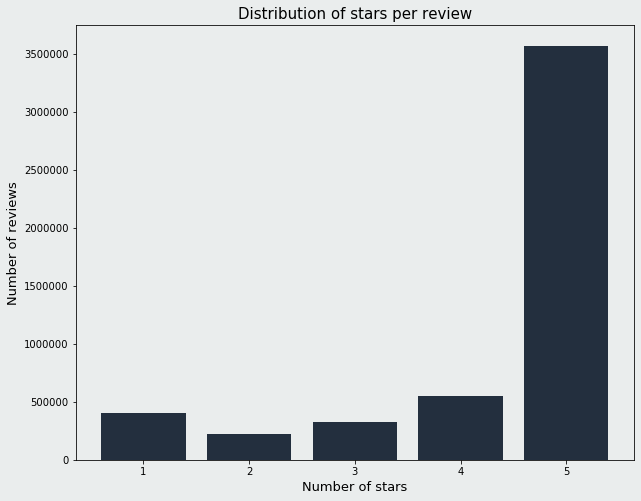

In [31]:
plot_bar_distribution(reviews['stars'],\
                      title="Distribution of stars per review",\
                      xlabel="Number of stars",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

As you can see a vast majority of reviews give 5 stars, but there are more 1 star than 2 or 3 stars, which is intersting. We can see that people usually review in the extreme either they think it's good so they give 4 or 5, or they thought it's trash and give 1.

Let's now take a look at `verified`.

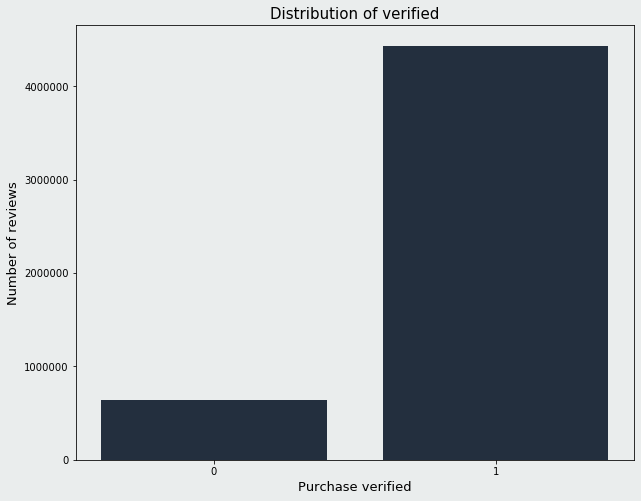

In [32]:
plot_bar_distribution(reviews['verified'],\
                      title="Distribution of verified",\
                      xlabel="Purchase verified",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

This is interesting and good news! As we can see most of the reviews are verified, so most of the reviews come from people that actually bought the product.

Let's plot the distribution of upvotes and compare it with the power law.

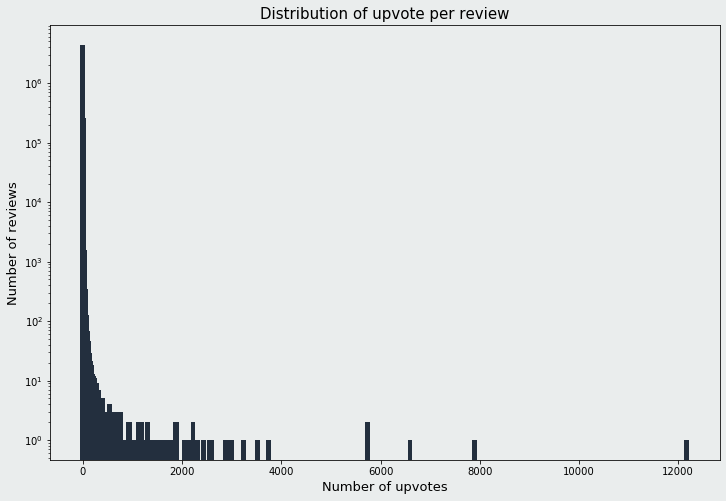

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


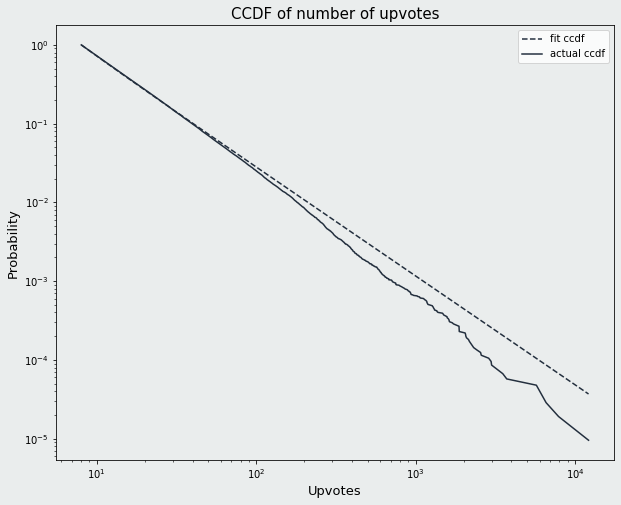

In [33]:
plot_bar_distribution(reviews['upvote'],\
                      title="Distribution of upvote per review",\
                      xlabel="Number of upvotes",\
                      ylabel="Number of reviews",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['upvote'],\
                    title="CCDF of number of upvotes",\
                    xlabel="Upvotes",\
                    ylabel="Probability")

We can see that it indeed follows a power law, most of the reviews have 0 upvotes, but there are some with a high amount of upvotes.

Something to note that'll be able to see later on is that reviews with a huge amount of upvotes probably are jokes or memes. Otherwise it doesn't really make sense for a review to have so many upvotes.

Let's take a look at `reviewText` we can try to plot the distribution of the length of the reviews. It should also follow a power law.

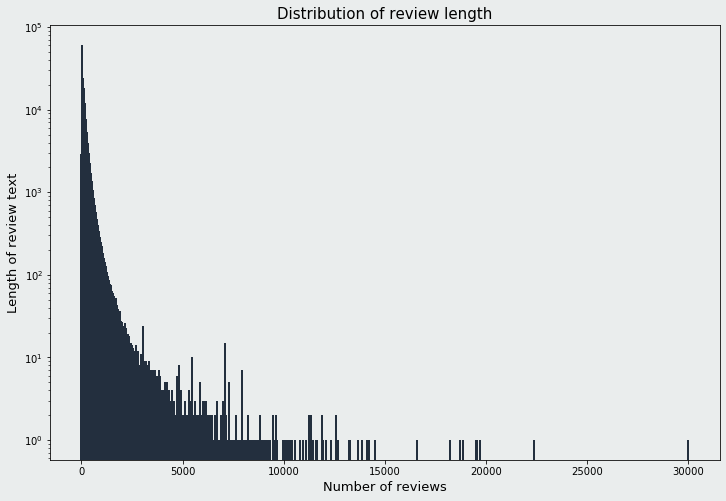

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


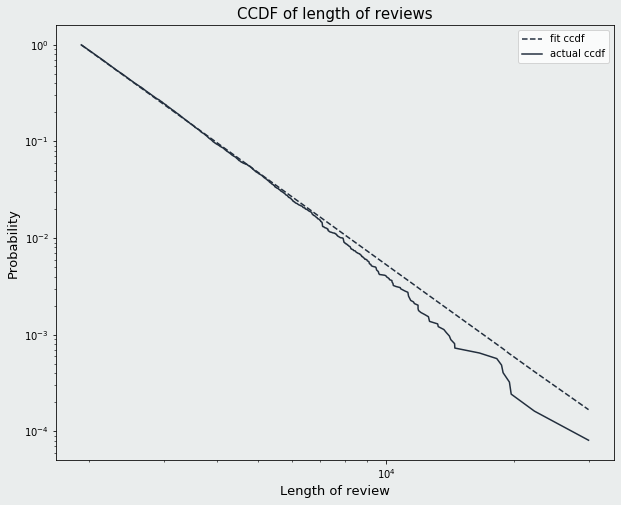

In [34]:
plot_bar_distribution(reviews['reviewText'].str.len(),\
                      title="Distribution of review length",\
                      xlabel="Number of reviews",\
                      ylabel="Length of review text",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['reviewText'].str.len(),\
                    title="CCDF of length of reviews",\
                    xlabel="Length of review",\
                    ylabel="Probability")

Again, it follows a power law, which is to be expected.

Now let's take a look at how many reviews we have over time, using the date. This give us some information about how much reviews we have and if the number of reviews during the year is linear or constant, or on the contrary if it's varying a lot.

In [49]:
def write_plot_html(plot, file_name, open_plot=False):
    file_name = f"{PLOTS_LOCATION}{file_name}.html"
    output_file(file_name)
    if open_plot:
        show(plot)
    else:
        save(plot)
    return FileLink(file_name)

In [87]:
reviews_per_date = reviews[['reviewTime']].copy()
reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
reviews_per_date.sort_index(inplace=True)

tools = "pan, wheel_zoom"
source = ColumnDataSource(reviews_per_date)

p = figure(plot_width=1600, plot_height=900, tools=tools, x_axis_type="datetime", title="Review count", x_axis_label="Date", y_axis_label="Number of reviews")
p.line('reviewTime', 'count', source=source, color=LINE_COLOR)

color_style_plot_bokeh(p, legend=False)

write_plot_html(p, "all_reviews")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/all_reviews.html

If you go to the above link (you may need to click on "Trust HTML", you can enable wheel zoom on the right and move the view by dragging), you can see that the number of reviews varies a lot during the year, but is globally increasing over time. 2015 seemed to have been a the big starting year for Amazon food category, which confirms that picking the updated 2018 dataset was a good idea since it adds a lot of data. We can also see that some dates have a lot of reviews, which we'll look into, for example March 2016. Something interesting is that our dataset ends in 2018 but as you can see it doesn't end abruptly, it decays rapidly, so we have to keep that in mind, we lack a lot of reviews in the 2018 year.

To look into it a bit deeper we can look at the distributions over year and month.

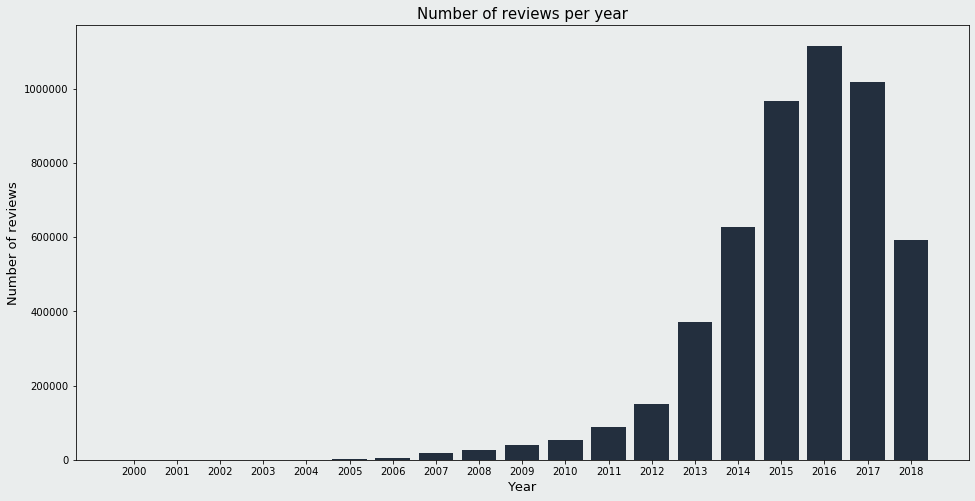

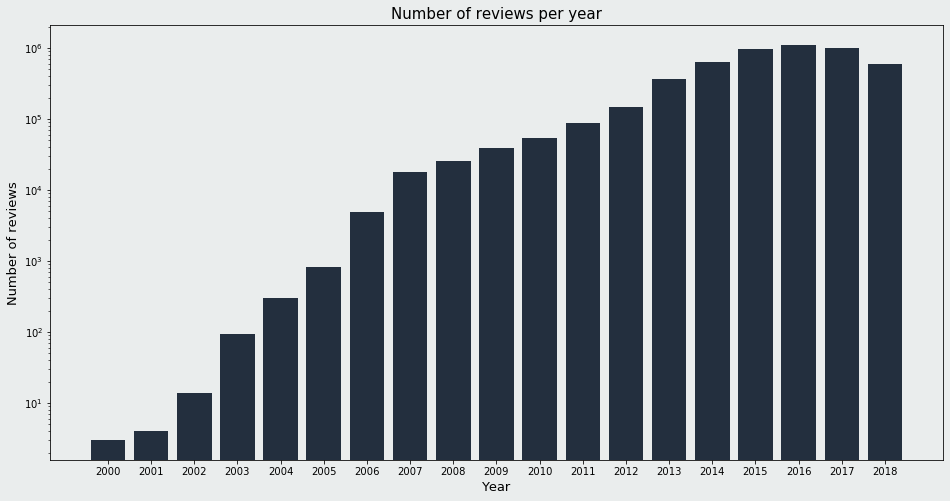

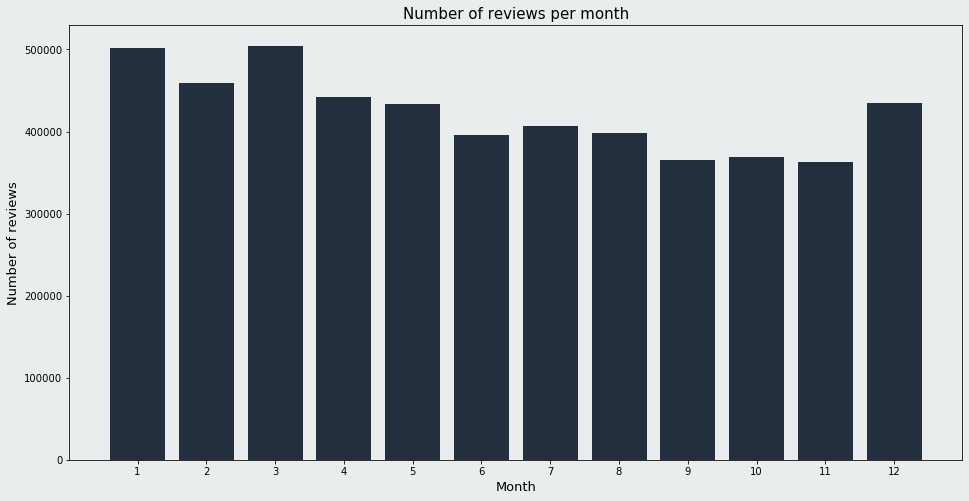

In [37]:
reviews_year = reviews['reviewTime'].map(lambda date: date.year)
args_year = {"data": reviews_year,\
             "title": "Number of reviews per year",\
             "xlabel": "Year",\
             "ylabel": "Number of reviews",\
             "figsize": (16, 8),\
             "categorical": True}

plot_bar_distribution(**args_year)
plot_bar_distribution(**args_year, yscale="log")

reviews_month = reviews['reviewTime'].map(lambda date: date.month)
plot_bar_distribution(reviews_month, title="Number of reviews per month", xlabel="Month", ylabel="Number of reviews", figsize=(16, 8), categorical=True)

As we can see, it indeed increases over the years, except 2018 as we lack reviews.

For the months it's somewhat even, but we can see that Winter is more popular, with Christmas, New Year, Valentine's Day and so on.

## 3. Keywords analysis for topic extraction

In order to dive deeper into the analysis of our dataset we start to analyse how topics are reprensented in products name and description. The approach here is the following :

    1. Choose a topic
    2. Choose keywords that are likely to appear in products' title and description, keywords that describe the topic
    3. Identify associated products
    4. Compute and plot the yearly proportion of reviews that those products represent, which corresponds to the 
    evolution of the topic popularity

To maximize the performance of the topic extraction, we pre-process the text with a standard nlp pipeline. What is important to us is only the words present in the text, we can thus remove the punctuation and the numbers. We remove the stopwords as well, to reduce the variability of what will become our tokens. We will check for the presence of words in the text so the lemmatization is really useful for us, it will reduce the false negative rate when extracting products for one topic.

### NLP pipeline and lemmatization

In [27]:
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger');

def remove_punctuation(s):
    punct_chars = string.punctuation
    translator_punct = s.maketrans(punct_chars, ' ' * len(punct_chars))
    
    return s.translate(translator_punct)

def remove_numbers(s):
    numbers = '0123456789'
    translator_num = s.maketrans(numbers, ' ' * len(numbers))
    
    return s.translate(translator_num)

def remove_stopwords(s):
    stopwords_np = np.array(stopwords.words('english'))
    words = np.array(s.split())
    words_filtered = words[~np.in1d(words, stopwords_np)]
    
    return ' '.join(words_filtered)

def transform_tag(tag):
    """
    Helper function for the lemmatization. This function maps the tag passed 
    as argument to the appropriate tag accepted by the lemmatize function.
    """
    tag_prefix = tag[0].lower()
    if tag_prefix in ['n', 'r', 'v', 'j']:
        return 'a' if tag_prefix == 'j' else tag_prefix
    else:
        return 'n'

def lemmatize(t, return_list=True):
    t = str.lower(t)
    t = remove_numbers(t)
    t = remove_punctuation(t)
    t = remove_stopwords(t)
    t_token = word_tokenize(t)
    t_tags = pos_tag(t_token)
    t_lemm = [lemmatizer.lemmatize(w, transform_tag(t)) for w, t in t_tags if len(w) > 1]
    if return_list:
        return t_lemm
    else:
        return ' '.join(t_lemm)

[nltk_data] Downloading package punkt to /home/flo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/flo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We now apply this pipeline, we lemmatize all descriptions of products, i.e. the description and the title in the metadata.

In [32]:
%%capture
meta['description'] = meta['description'].parallel_apply(lemmatize)
meta['title'] = meta['title'].parallel_apply(lemmatize)
meta.to_csv('data/meta_lemm')

### Word2Vec model creation

In [55]:
import gensim.models

descriptions_and_titles = meta[['description', 'title']].to_numpy().ravel()
model = gensim.models.Word2Vec(sentences=descriptions_and_titles, workers=4, min_count=10)

Let's quickly see if our model permit to get results that make sense

**Show that the model make sense with things as below (have to re-run the cell)**

In [211]:
model.wv.most_similar('italy')

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('campania', 0.6908035278320312),
 ('greece', 0.6781868934631348),
 ('naples', 0.6767177581787109),
 ('tuscany', 0.6587968468666077),
 ('veneto', 0.6473205089569092),
 ('parma', 0.641181230545044),
 ('spain', 0.6410231590270996),
 ('sicily', 0.6375719308853149),
 ('emilia', 0.635952889919281),
 ('lazio', 0.6327407956123352)]

In [51]:
labels = pd.read_csv('./to-label/to-label-2.csv', header=None, na_values="None",\
                     names=["asin", "title", "description", "healthy/natural", "vegetarian/vegan", "local", "sport/productivity", "country"])

### Food trends extraction

In [52]:
def get_values_for_col(col):
    values = labels[col][labels[col].notnull()].str.\
                split(', ').\
                explode().\
                unique()
    return values

In [56]:
healthy_natural = get_values_for_col("healthy/natural")
healthy_natural

array(['superior quality', 'highest standards', '100% natural', 'low fat',
       'good source of fiber', 'quality', 'finest', 'organic',
       'all natural', 'fat free', 'cholesterol free', 'sodium free',
       'gluten free', 'lactose free', 'Organics', 'natural way',
       'without chemical fertilizers', 'without insecticides',
       'without herbicides', 'healthy', 'natural', 'health', 'well-being',
       'highest-quality', 'healthy living', 'gluten-free', 'dairy-free',
       'thin', 'antioxidants', 'very best', 'with care',
       'quality products', 'ethically'], dtype=object)

In [347]:
healthy_natural = ['100% natural', 'low fat', 
                   'good source of fiber', 'organic', 'organically'
                   'all natural', 'fat free', 'cholesterol free', 'sodium free',
                   'all natural', 'fat-free', 'cholesterol-free', 'sodium-free',
                   'gluten free', 'lactose free', 'Organics',
                   'without chemical fertilizers', 'without insecticides',
                   'without herbicides', 'highest-quality', 'healthy living', 'gluten-free', 'dairy-free',
                   'without herbicides', 'highest-quality', 'healthy living', 'gluten free', 'dairy free',
                   'quality products', 'ethically']

def plot_difference_total(keywords, name, meta_df):
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    reviews_per_date = reviews[['reviewTime', 'asin']].copy()
    reviews_per_date = reviews_per_date[['reviewTime']][reviews_per_date['asin'].isin(asins)]
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
    reviews_per_date.sort_index(inplace=True)
    
    tools = "pan, wheel_zoom"
    source = ColumnDataSource(reviews_per_date)
    
    
    p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
    p.line('reviewTime', 'count', source=source, color="#ff0000", legend_label=name)
    
    reviews_per_date = reviews[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
    reviews_per_date.sort_index(inplace=True)
    
    tools = "pan, wheel_zoom"
    source = ColumnDataSource(reviews_per_date)
    
    
    p.line('reviewTime', 'count', source=source, color="#0000ff", legend_label="total")
    
    p.legend.click_policy="hide"
    
    return write_plot_html(p, name)

def plot_proportion(keywords, name, meta_df):
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    reviews_per_date_interest = reviews[['reviewTime', 'asin']].copy()
    reviews_per_date_interest = reviews_per_date_interest[['reviewTime']][reviews_per_date_interest['asin'].isin(asins)]
    reviews_per_date_interest = pd.DataFrame(reviews_per_date_interest.groupby('reviewTime').size(), columns=['count_interest'])
    reviews_per_date_interest.sort_index(inplace=True)
    
    reviews_per_date = reviews[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count_total'])
    reviews_per_date.sort_index(inplace=True)
    
    reviews_per_date = reviews_per_date.join(reviews_per_date_interest)
    reviews_per_date["proportion_interest"] = reviews_per_date["count_interest"].fillna(0) / reviews_per_date["count_total"]
    reviews_per_date["proportion_total"] = np.ones(len(reviews_per_date.index))
    
    tools = "pan, wheel_zoom"
    source = ColumnDataSource(reviews_per_date)
    
    
    p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
    p.line('reviewTime', 'proportion_interest', source=source, color="#ff0000", legend_label=name)
    p.line('reviewTime', 'proportion_total', source=source, color="#0000ff", legend_label="total")
    
    return write_plot_html(p, name)

In [431]:
def plot_proportion_year(keywords, meta_df, min_date, max_date, title):
    # Find products that contain at least one of the keywords
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    # Only take into account reviews that are withing the given time period
    reviews_year = reviews.copy()
    reviews_year = reviews_year[(reviews_year['reviewTime'] >= min_date) & (reviews_year['reviewTime'] <= max_date)]
    reviews_year['reviewTime'] = reviews_year['reviewTime'].apply(lambda date: date.year)
    
    # Count how many review per year there were on these products
    reviews_per_date_interest = reviews_year[['reviewTime', 'asin']].copy()
    reviews_per_date_interest = reviews_per_date_interest[['reviewTime']][reviews_per_date_interest['asin'].isin(asins)]
    reviews_per_date_interest = pd.DataFrame(reviews_per_date_interest.groupby('reviewTime').size(), columns=['count_interest'])
    
    # Count total number of reviews per year
    reviews_per_date = reviews_year[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count_total'])
    
    # Compute percentage of reviews that are about the selected products
    reviews_per_date = reviews_per_date.merge(reviews_per_date_interest, left_index=True, right_index=True)
    reviews_per_date["proportion_interest"] = reviews_per_date["count_interest"].fillna(0) / reviews_per_date["count_total"] # fillna just in case
    
    # Get years and proportions
    reviews_per_date.sort_index(inplace=True)
    years = reviews_per_date.index
    proportions = reviews_per_date["proportion_interest"].values
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.bar(years, proportions)
    
    # Show value on top of bar
    for a,b in zip(years, proportions):
        plt.text(a - .35, b + np.max(proportions)/100, f"{b*100:.2f}%", fontsize=13, fontweight='bold')

    plt.title(title, fontsize=15)
    plt.xlabel("Year", fontsize=13)
    plt.ylabel("Percentage", fontsize=13)

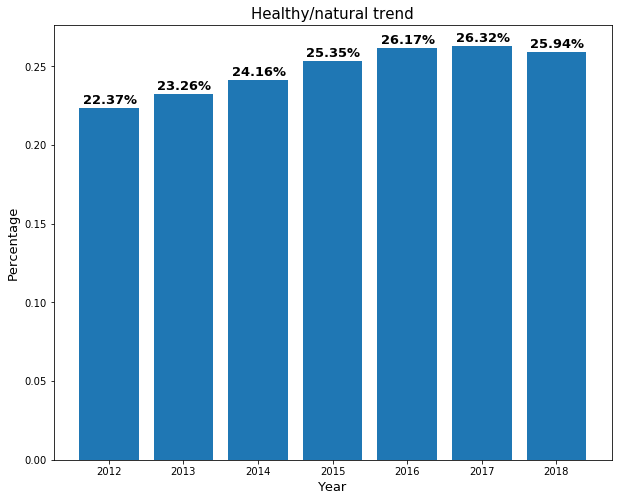

In [433]:
plot_proportion_year(healthy_natural, lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Healthy/natural trend")

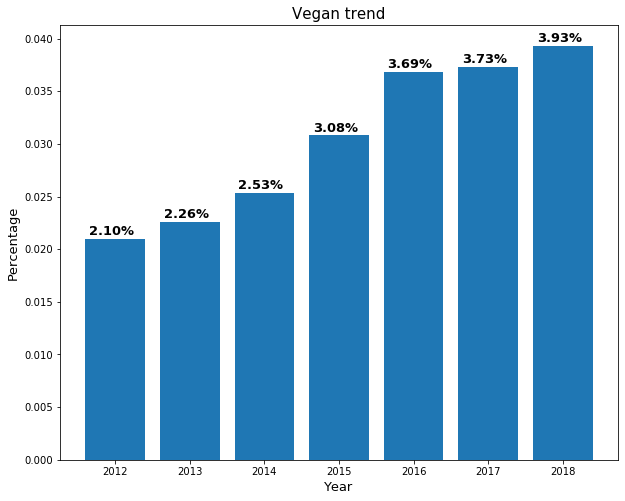

In [441]:
plot_proportion_year(["vegan"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Vegan trend")

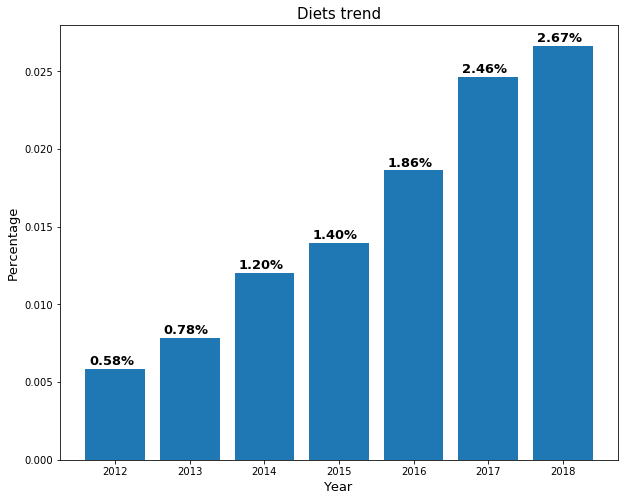

In [444]:
plot_proportion_year(["paleo", "keto", "ketogenic", "atkins"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Diets trend")

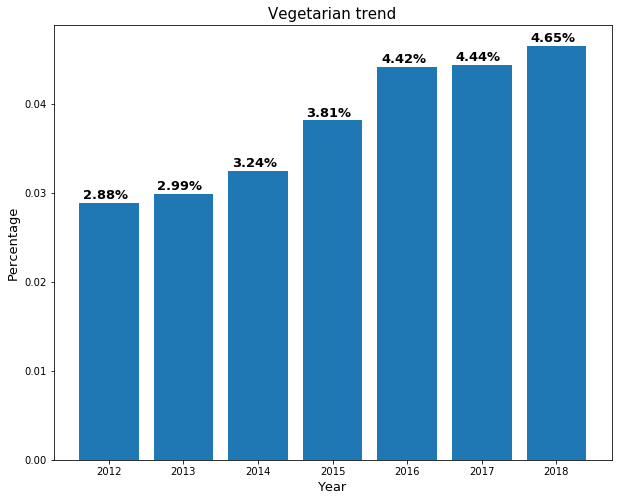

In [448]:
plot_proportion_year(["vegetarian", "tofu", "vegan", "meatless"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Vegetarian trend")

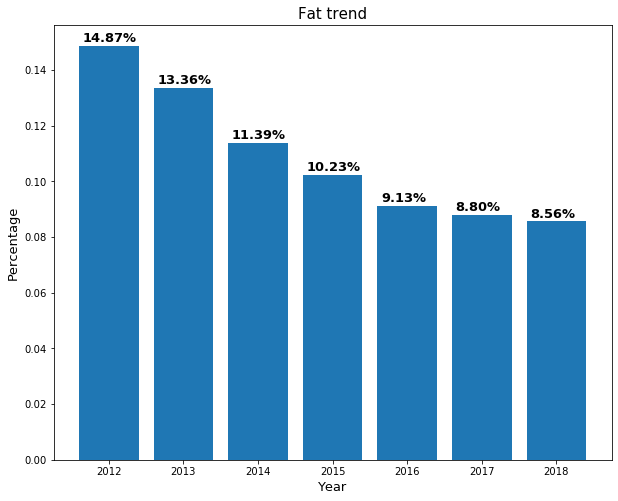

In [455]:
plot_proportion_year(["fat"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Fat trend")

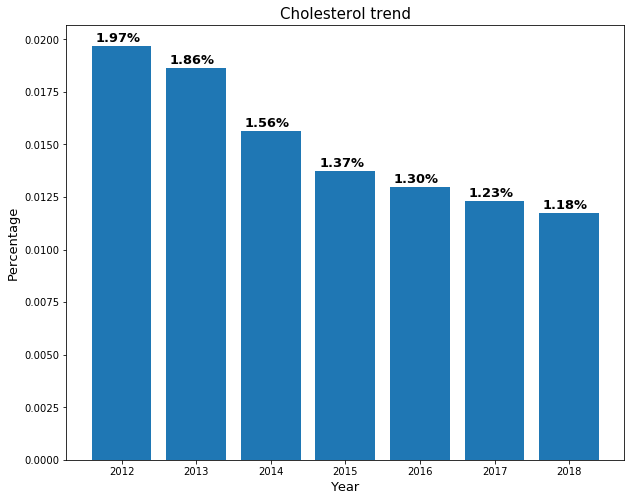

In [456]:
plot_proportion_year(["cholesterol"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Cholesterol trend")

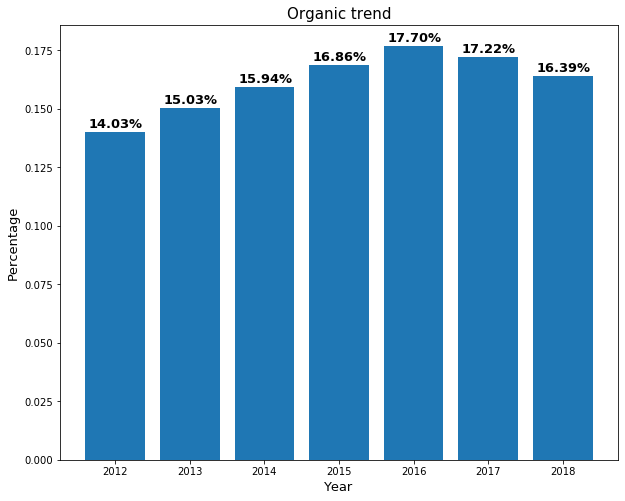

In [432]:
plot_proportion_year(['organic'], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Organic trend")

### A Country tour of the amazon food dataset

Bob

In [104]:
labels[labels["country"].notnull()]

,asin,title,description,healthy/natural,vegetarian/vegan,local,sport/productivity,country
1,B0046LF9IM,"Roland Curry Powder, Madras, 1 Pound (Pack of 4)","Our mission is to be the leader in importing and marketing superior quality specialty foods under our Roland brand and other brands, and to perform in all areas of our organization at levels that ...","superior quality, highest standards",NaN,NaN,NaN,"India, Madras"
6,B001FA1KN0,NaN,"All natural. Fat free, cholesterol free, and sodium free. Product of France. Chestnuts.","all natural, fat free, cholesterol free, sodium free",NaN,NaN,NaN,France
11,B001979YRI,"Oskri Date Fruit Bar, Gluten Free, 1.5-Ounce Bars (Pack of 20)","Gluten free. Lactose free. Oskri Organics is committed to offering the best products that are grown and prepared in a natural way, without the use of chemical fertilizers, insecticides, and herbic...","gluten free, lactose free, Organics, natural way, without chemical fertilizers, without insecticides, without herbicides",NaN,Made in the USA,NaN,USA
14,B001EQ543M,NaN,"Asia/Pacific: Coffees from Asia/Pacific are full-flavored with characteristics that range from the assertive, herbal spiciness and depth that typify the semi-washed coffees of Indonesia to the bal...",NaN,NaN,NaN,NaN,"Asia, Pacific"
20,B00B8BQ3ZG,Hormel Compleats Cafe Creations Three Cheese Chicken Pasta 9 oz,"Inspected for wholesomeness by U.S. Department of Agriculture. Infused with unique seasonings & flavors. Feeling adventurous? Try all our exciting recipes! Water, Pasta (Durum Wheat, Water, Egg Wh...",NaN,NaN,NaN,NaN,"Swiss, American"
22,B000F3XZEK,"Taylors of Harrogate, Gunpowder Tea, Loose, 35.3 Ounce","Speciality Leaf Tea. Family tea merchants. Est. 1886. We are a traditional family business, based in England's beautiful Yorkshire Dales. For over a century we've taken pride in selecting the very...","antioxidants, very best, with care",NaN,"family, traditional family business",NaN,England


In [179]:
countries = ["switzerland|swiss", "italy|italian", "japan|japanese", "china|chinese", "england|english", "mexico|mexican", "india|indian", "german"]

In [168]:
lemmatized = pd.read_csv('./processed-data/meta_lemm.csv')

In [169]:
lemmatized

,Unnamed: 0,category,description,title,brand,rank,main_cat,price,asin,date
0,0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",beemster gouda cheese age month,beemster gouda age month app lb,Ariola Imports,"165,181inGroceryGourmetFood(",Grocery,41.91,0681727810,NaN
1,1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,ship uk please allow business day arrival ex lib pub apply science publisher ltd,trim healthy mama xylitol,NaN,"315,867inGroceryGourmetFood(",Grocery,NaN,0853347867,NaN
2,2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers||Cake Toppers",jazz cake sparkle monogram sparkle collection single letter monogram silver plat covered crystal rhinestone come several size convenience use simple yet elegant monogram cake topper make sweet eve...,letter swarovski crystal monogram wed cake topper letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers",Amazon Home,29.95,1888861118,2010-09-21
3,3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers||Cake Toppers",large letter height,letter swarovski crystal monogram wed cake topper letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers",Amazon Home,11.45,1888861517,2011-09-11
4,4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers||Cake Toppers",NaN,letter swarovski crystal monogram wed cake topper letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers",Amazon Home,15.00,1888861614,2011-09-11
...,...,...,...,...,...,...,...,...,...,...
283507,287204,"Grocery & Gourmet Food||Jams, Jellies & Sweet Spreads||Jams, Jellies & Preserves",caffarel fruit jelly product italy caffarel fruit jelly organic assorted gram bag assort fruit jelly ingredients sugar glucose fructose syrup water concentrate fruit juice cherry raspberry blueber...,caffarel fruit jelly organic assorted bag,Caffarel,"369,384inGroceryGourmetFood(",Grocery,NaN,B01HJFBN9A,NaN
283508,287205,Grocery & Gourmet Food||Condiments & Salad Dressings||Mayonnaise,hampton creeks mayo truffle make fancy food simple sandwich youre put perfect way take favorite food next level subtle earthy flavor wont want skimp make meal memorable mayo truffle number contain...,hampton creek spo truffle mayo ounce,Hampton Creek,"113,710inGroceryGourmetFood(",Grocery,10.89,B01HJFC704,NaN
283509,287206,Grocery & Gourmet Food||Condiments & Salad Dressings||Salad Dressings||Ranch,nothing compare classically zesty flavor hampton creeks ranch creamy savory hard resist make dress choice whether youre salad fiend dunk favorite food flavor perfect ranch never go style ranch sat...,hampton creek ranch dress fluid ounce,Hampton Creek,"21,731inGroceryGourmetFood(",Grocery,10.95,B01HJF6FRA,NaN
283510,287207,"Grocery & Gourmet Food||Herbs, Spices & Seasonings||Single Herbs & Spices||Vanilla Beans",NaN,gourmet pure vanilla bean paste organically grown contains whole vanilla seed hand pick heilala vanilla pod natural superior tahitian mexican madagascar paste,Heilala Vanilla,472inGroceryGourmetFood(,Grocery,14.97,B01HJHSVG6,NaN


In [275]:
def check_country_interest(keywords, meta_df, model):
    nrows = ceil(len(keywords)/2)
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches((10*ncols,8*nrows))
    
    for i, keyword in enumerate(keywords):
        products = meta_df[['title', 'description']][(meta_df["title"].str.contains(keyword)) |\
                                                     (meta_df["description"].str.contains(keyword))]
        counts = [
            len(products[(products['title'].str.contains(country)) |\
                        (products['description'].str.contains(country))].index)
            for country in countries
        ] 
        similarities = np.array([
            model.wv.n_similarity(country.split('|'), [keyword])
            for country in countries
        ]).clip(0, 1)
        
        row = i//2
        col = i % 2
        width = 0.35
        indx = np.arange(len(countries))
        
        ax = axs[row,col]
        ax2 = axs[row,col].twinx()
        
        ax.set_xticklabels(["padding"] + [country.split('|')[0] for country in countries], rotation=30, fontsize=13)
        ax.set_title(f"Country count for {keyword}", fontsize=15)
        
        l1 = ax.bar(indx - width/2, counts, width=width, label="count")
        ax.set_ylabel("Count", fontsize=13)
        l2 = ax2.bar(indx + width/2, similarities, color='red', width=width, label="similarity")
        ax2.set_ylim(0,1)
        ax2.set_ylabel("Word2Vec similarity", fontsize=13)
        
        plt.legend(handles=[l1, l2])
    
    plt.show()

In [276]:
model.wv.n_similarity(["switzerland", "swiss"], ["coffee"])

0.2388226

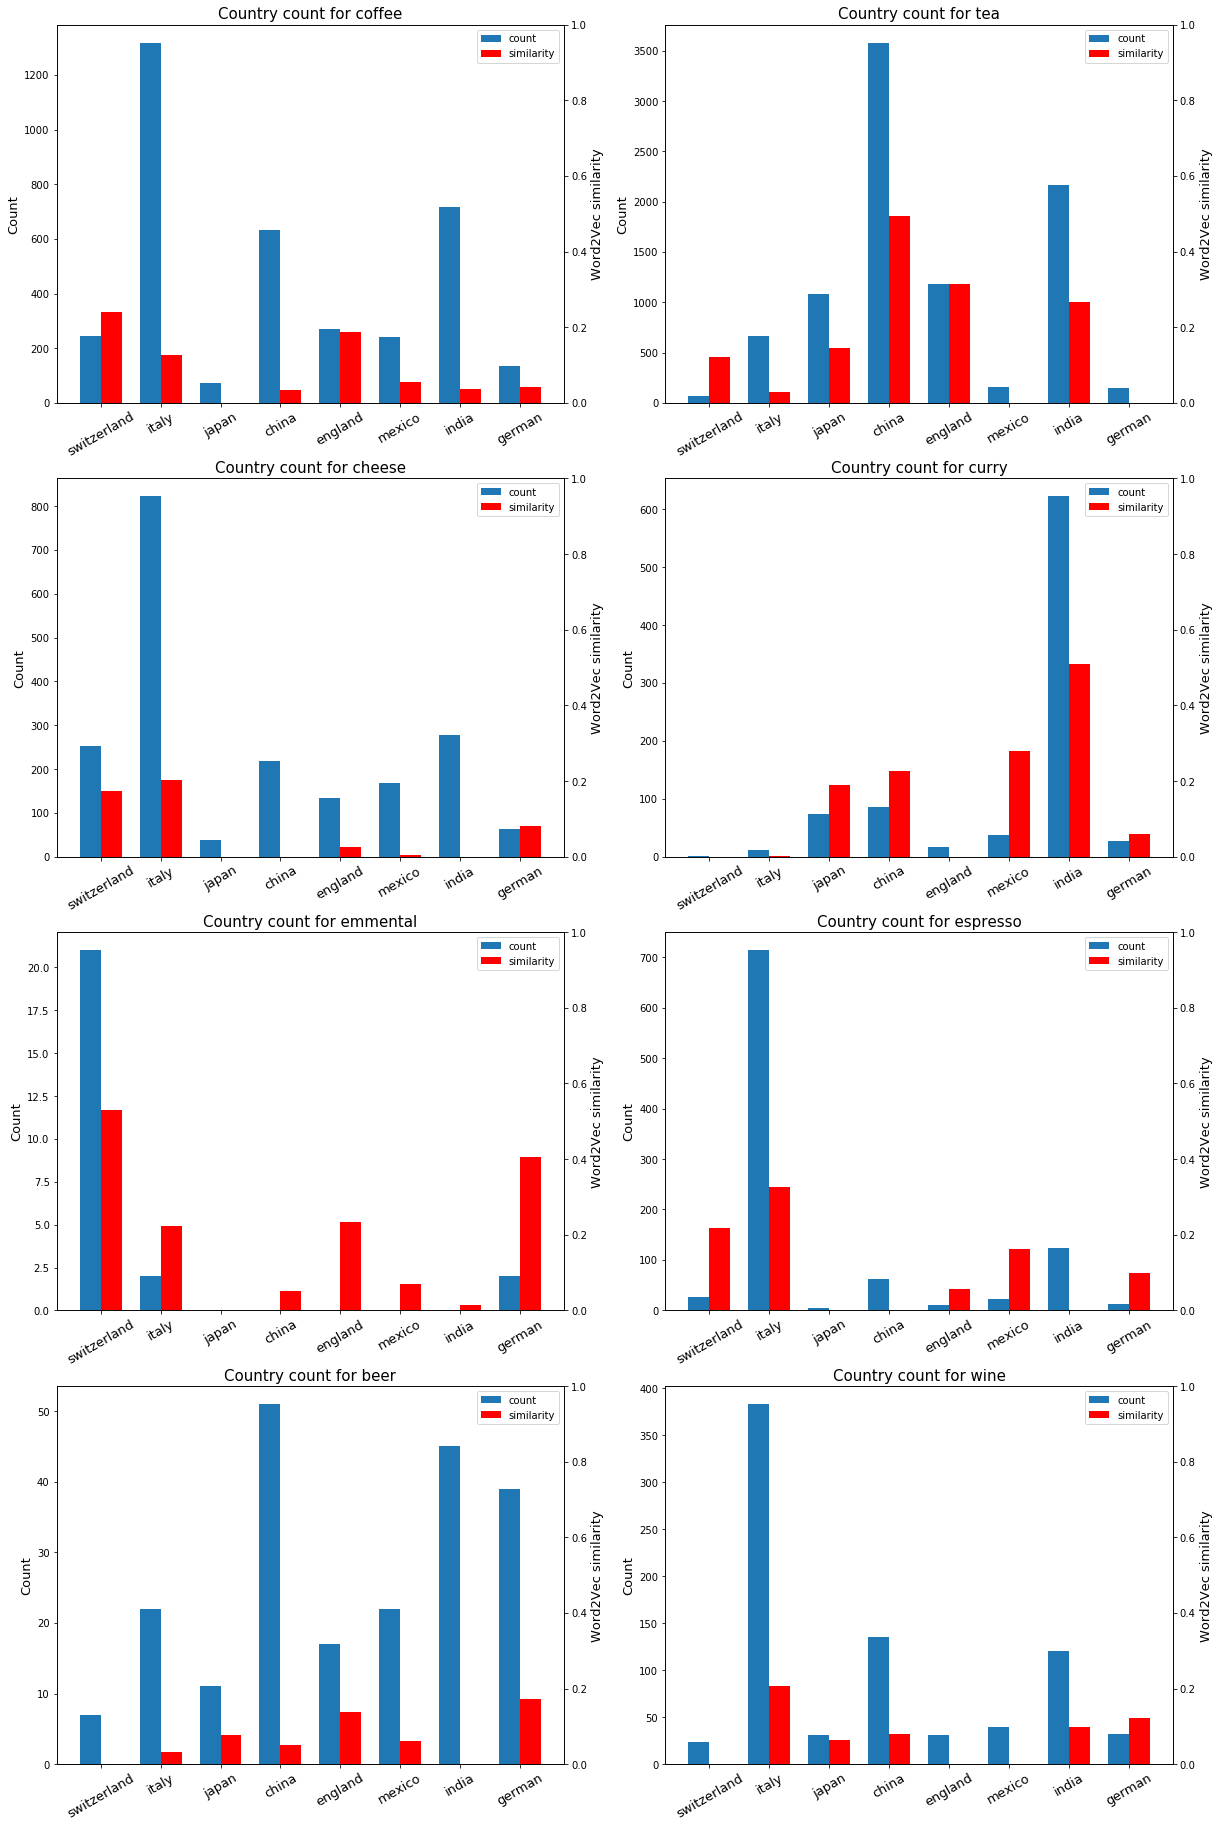

In [313]:
check_country_interest(["coffee", "tea", "cheese", "curry", "emmental", "espresso", "beer", "wine"], lemmatized, model)

## 4 Analysis of the products' popularity through their number of review's time serie

In this section, we analyse how the number of reviews is affected throughout the years. The purpose here is to gain insights about how a particular event affects what people buy on amazon. The analysis is splitted into three parts :
    
    1. The first one consists in showing preliminary results about those time series with two examples that shows how we can analyse our dataset with such a method 
    
    2. 

### 2.3.0 Preliminary results

In [22]:
def compute_reviews_per_week(reviews, minimum_review):
    """
    Create dataframe with number of reviews per product per week, based on the {reviews} dataframe, keep only 
    the ones that have at least {minimum_review} during a week
    """ 
    reviews_per_week = pd.DataFrame(reviews[['asin', 'reviewTime']].groupby(['asin', pd.Grouper(key='reviewTime', freq='W')]).size(), columns=['reviewCount'])
    reviews_per_week = reviews_per_week.groupby(['asin']).filter(lambda row: row.to_numpy().max() > minimum_review)
    reviews_per_week.reset_index(inplace=True)
    return reviews_per_week

In [23]:
reviews_per_week = compute_reviews_per_week(reviews, 7)

In [94]:
def plot_time_series(ids, plot_filename, title, open_plot=False):
    """
    Create an interactive plot that show the evolution of the number of reviews for the 
    given products
    
    :param ids: an iterable with the ids (asin) that will be in the plot
    :param plot_filename: the filename of the produced plot
    :return: the path to the plot
    """
    tools = "pan, wheel_zoom"
    p = figure(plot_width=1600, plot_height=900, tools=tools, x_axis_type="datetime", title=title, x_axis_label="Date", y_axis_label="Review count")
    num_colors = np.clip(len(ids), 3, 20)
    colors = d3['Category20'][num_colors]
    
    for i, asin in enumerate(ids):
        reviews_asin = reviews_per_week.loc[reviews_per_week['asin'] == asin, ['reviewTime', 'reviewCount']]
        reviews_asin.set_index('reviewTime', inplace=True)
        reviews_asin.sort_index(inplace=True)

        source = ColumnDataSource(reviews_asin)

        # If only one id give, use LINE_COLOR
        color = colors[i%20] if len(ids) > 1 else LINE_COLOR
        p.line('reviewTime', 'reviewCount', source=source, legend_label=str(asin), color=color, line_width=2, alpha=0.8)
    
    p.legend.click_policy = "hide"
    color_style_plot_bokeh(p)
    
    return write_plot_html(p, plot_filename, open_plot)

In [106]:
# Plot the time series of a sample (first 10'000 product) of origin dataframe
reviews_per_week_sample = reviews_per_week.loc[reviews_per_week['asin'].isin(reviews.loc[:10000, 'asin']).values, :]
plot_time_series(reviews_per_week_sample['asin'].unique(), "time_series_first_10000", "Review count for products that got popular")

/home/flo/EPFL/Ada/Los-Moussaka-ADA/milestone-2-plots/time_series_first_10000.html

As before, this is an interactive plot for which you may have to "trust" to see. 

In [27]:
id1 = "B0000CFH7B"
id2 = "B0000D916Y"
display(meta["title"][meta["asin"] == id1].values[0])
meta["title"][meta["asin"] == id2].values[0]

'Wilton 710-5506 Color Mist Spray 1.5oz, Black'

"David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb."

In [28]:
id_spray = id1
id_cookie = id2

reviews_spray = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", 'verified']]\
                        [(reviews["asin"] == id_spray) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2015-05-22")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2015-06-15"))]

display(reviews_spray)
date_with_max_reviews = reviews_spray.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
4197,2015-06-15,A1Q6MV8HRC58KK,If you go back to the beginning of the reviews there are about 13 pages of nonsense about baking...,Best Shine in the Wasteland,66,5,False
4198,2015-06-13,ABD1G0MCG2QHT,"My cupcakes are all shiny and chrome. I eat, I poop, I eat again.",Five Stars,47,5,False
4199,2015-06-12,A3OX7K7TZ1A6IG,I BUY! I RETURN! I BUY AGAIN!!,Five Stars,123,5,False
4200,2015-06-12,A3N37GJGVFUDJB,Mitch has witnessed me!!!,Five Stars,11,5,False
4201,2015-06-11,ABZC6GUF3EZR9,IT BURNS OH IT BURNS WONDERFULLY\nTHE PATH TO VALHALLA IS NOT A PAINLESS ONE,SHINY AND CHROME,77,5,True
...,...,...,...,...,...,...,...
4363,2015-05-25,A2ANPUFYSVCZCM,Oh what a spray! What a lovely spray!,"So Shiny, So Chrome",3001,5,False
4364,2015-05-23,A3VM93YDITI5DK,Makes it really easy to spot a Warboy who is at the end of their half life and about to become a...,"Brightens up my world, which is fire and blood.",161,5,False
4365,2015-05-23,A1B6CBLRIA9FR1,I LIVE! I DIE! I LIVE AGAIN!,Four Stars,715,4,False
4366,2015-05-23,A29I5F4VUJYXUU,WE WILL RIDE THROUGH THE GATES OF VALHALLA SHINY AND CHROME! WITNESS ME!,Five Stars,1070,5,False


Date with max number of reviews: 2015-05-27


This is quite funny, we managed to find approximately the release date of the famous movie [Mad Max: Fury Road](https://en.wikipedia.org/wiki/Mad_Max:_Fury_Road), which released in 15th May 2015 in USA. But how does a spray relate to this movie, you may wonder, if you haven't seen the movie. In fact the chrome spray became kind of a meme because of popular quotes, otherwise known as the "[Witness me !](https://knowyourmeme.com/memes/witness-me)" meme. In fact most of the reviews quote the movie or change a little bit a quote for comedic effect. Here is a gif of the famous spray inside of the movie:

<img src="https://media.giphy.com/media/vHIz00fcNbseQ/giphy.gif">

The popular quotes include:
> <em>&ldquo;You will ride eternal, shiny and chrome.&rdquo;</em>

> <em>&ldquo;Return my treasures to me, and I myself will carry you through the gates of Valhalla. You shall ride eternal. Shiny, and chrome!&rdquo;</em>

> <em>&ldquo;I live, I die, I live again!&rdquo;</em>

> <em>&ldquo;Witness me.&rdquo;</em>

Of course, the dates that are popular in the reviews are not exactly at the release date but a couple days later and lasted ~3 weeks for this product. The delay can be explained by the fact that the meme wasn't born instantly, people made joke about it, it became popular and ultimately invaded some of the reviews. We can see that most of the reviews have many upvotes. In fact reviews with many upvotes are almost always memes or jokes, so we have to take that into account. If we see many reviews with little upvotes it's probably a product that got popular, but if they have many upvotes it is most likely due to a meme or a group effect.

We can expect other sprays to have similar trends, because the "Witness Me!" meme effect may have affected other sprays on Amazon.

To illustrate that, let's see what does the second product tells us. We begin by showing the reviews of the product during the peak, along with when the trend take place.

In [29]:
reviews_cookie = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", "verified"]]\
                        [(reviews["asin"] == id_cookie) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2017-12-08")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2018-01-22"))]

display(reviews_cookie.head(10))
date_with_max_reviews = reviews_cookie.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
7934,2018-01-22,A1VLIWG4U2V54G,"I'm not a huge cookie guy. These were wonderful. Very fresh, very delicious.",These were wonderful. Very fresh,0,5,True
7935,2018-01-22,A129TBMOQD79CZ,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,0,5,False
7936,2018-01-21,A3TYIIZND9LAI4,"These cookies are delicious. They are fresh, soft, flavorful, and the best oatmeal raisin cookie...",Best cookie ever,0,5,True
7937,2018-01-16,AEE3R04IH4T43,"The best cookies ever so chewy, sweet and tasty!",Very good cookies,0,5,True
7938,2018-01-15,AEHEL2XO4RMRF,put in oven before eating,Four Stars,0,4,True
7949,2018-01-15,A2I88LLDJ5UHSA,"Good deal,gift well received",Five Stars,0,5,True
7950,2018-01-15,AX37FB41O04J2,Was sent as a gift. Found a hair baked into a cookie. Good until that point,Good until that,0,2,True
7951,2018-01-15,ARDJ0F5J1V8VV,"They were good and tasty, a very delicious cookie. Fresh baked flavor! The cookie looks and tast...",Tastes and looks full of homemade goodness,0,5,False
7952,2018-01-12,A1OD4XDOWM8S6E,Would be 5 stars if the raisin cookies didn't take over the flavor of every other cookie. They d...,"Theyre good, just get the package without raisins...",0,4,True
7953,2018-01-11,AJO8G0GEMPAAU,"Got them as a Birthday treat for my dad, he said they were delicious!",Four Stars,0,4,False


Date with max number of reviews: 2017-12-15


One way to compare the two product is to see the proportion of people that have actually bought them. If the popularity of one of them comes from the fun in the comments and not from the product itself, we can suppose that the proportion of people that bought the product is quite low. However, in the other situation where the popularity depends on the quality, this proportion should be much higher.

In [249]:
print("Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:")
verif_proportion_spray = reviews_spray['verified'].sum() / reviews_spray['verified'].size
verif_proportion_cookie = reviews_cookie['verified'].sum() / reviews_cookie['verified'].size
print("Spray product: %.1f%%" % (verif_proportion_spray*100))
print("Cookie product: %.1f%%" % (verif_proportion_cookie*100))

Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:
Spray product: 2.3%
Cookie product: 62.7%


We can see how different they are in this measure, this confirms our intuition that reviews from the spray are simply memes. So, coming from people that didn't buy the product, but just posted a review as a joke.

Another thing is that, unlike the first product, all reviews tend to have 0 upvote for the cookie product. This confirms that the popularity comes from people that actually wanted to buy cookies and thought they were good. Not from people that are joking. Also, the peak of interest here is an effect of christmas festivities, the product's goal is to be a gift so it is no wonder that the day which got the most interest is just before christmas day.

Now that we have seen that looking at popularity of products can give us a good insight we decided to do it in a more controlled manner by targeting Christmas instead of shooting in the dark like here.

To do this we search for product that got trendy, by measuring the difference between its mean, calculated on the number of reviews per week, in days around christmas with the median during all the year. That way, a product that gets more interest in the period of christmas will be picked. This shows how we can directly observe the effect of a certain event, here Christmas, on the dataset. We calculate it this way so that if the product experience a huge peak at that time, the baseline measure, the median here, is not affected since the median is robust. By taking the difference we have a bias towards product that get more attention in general but this is voluntary, focusing on popular products make the analysis more concrete.

For now, we focus on the two last christmas of the dataset, namely in years 2016 and 2017.

In [24]:
def compute_period_activity(reviews_per_week, start_date, time_delta):
    period_mask = (reviews_per_week['reviewTime'] >= start_date) & (reviews_per_week['reviewTime'] < start_date+time_delta)
    
    year_mask = (reviews_per_week['reviewTime'] >= pd.datetime(start_date.year, 1, 1)) & (reviews_per_week['reviewTime'] < pd.datetime(start_date.year, 12, 31))
    
    product_median_in_year = pd.DataFrame(reviews_per_week.loc[year_mask, :].groupby('asin')['reviewCount'].median())
    product_median_in_year.columns = ['median in year']
    
    period_mean = pd.DataFrame(reviews_per_week.loc[period_mask, :].groupby('asin')['reviewCount'].mean())
    period_mean.columns = ['mean in period']
    
    median_and_mean = product_median_in_year.join(period_mean)
    median_and_mean = median_and_mean.loc[(~median_and_mean['median in year'].isnull()) & (~median_and_mean['mean in period'].isnull()), :]
    median_and_mean['delta'] = median_and_mean['mean in period'] - median_and_mean['median in year']
    median_and_mean.reset_index(inplace=True)
    
    return median_and_mean

In [225]:
median_and_mean_2017 = compute_period_activity(reviews_per_week, pd.datetime(2017, 12, 18), pd.Timedelta('10 days'))
median_and_mean_2017['year'] = 2017
median_and_mean_2016 = compute_period_activity(reviews_per_week, pd.datetime(2016, 12, 18), pd.Timedelta('10 days')) 
median_and_mean_2016['year'] = 2016
median_and_mean = pd.concat([median_and_mean_2016, median_and_mean_2017])
asins_to_plot = median_and_mean.loc[median_and_mean['delta'] > 30, :].merge(meta[['asin', 'title', 'main_cat']], left_on='asin', right_on='asin')
asins_to_plot.drop_duplicates(inplace=True)
print('Products with a peak of interest')
display(asins_to_plot)

plot_time_series(asins_to_plot['asin'].unique(), 'time_series_christmas_peak')

Products with a peak of interest


,asin,median in year,mean in period,delta,year,title,main_cat
0,B0000D9169,3.0,57.5,54.5,2016,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",Grocery
2,B0000D916Y,3.0,57.5,54.5,2016,"David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",Grocery
4,B00KCCKV8W,15.5,293.0,277.5,2016,"Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, Mothers & Fathers Day ...",Grocery
5,B00KCCKV8W,24.5,56.0,31.5,2017,"Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, Mothers & Fathers Day ...",Grocery
6,B00SBT6E8E,2.0,43.0,41.0,2016,CollegeBox - Snacks Care Package (40 Count) for College Students – Variety Assortment Gift Box B...,Grocery
7,B00YPM5X2Y,8.0,55.5,47.5,2016,"Holiday Nuts Gift Basket -Delightful Gourmet Food Gifts Prime Delivery -Christmas Birthday, Than...",Grocery
8,B0131A6FJA,9.0,51.5,42.5,2016,96 Count Variety (10 Amazing Blends) Single-serve Cups for Keurig K-cup Brewers - Premium Roaste...,Grocery
9,B013KTYFYO,7.0,44.5,37.5,2016,Cookies Chips & Candy Snacks Assortment Bulk Sampler by Variety Fun (Care Package 40 Count),Grocery
10,B015G9SH6I,8.0,44.5,36.5,2016,"Five Star Gift Baskets, Holiday Gift Basket - Gourmet Food Nuts and Chocolate, 3 Different Delic...",Grocery
11,B01E9D0OR2,19.0,69.0,50.0,2017,Little Stinker The Original Bag of Unicorn Farts Cotton Candy Funny Novelty Gift for Unique Birt...,Grocery


/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/time_series_christmas_peak.html

One thing is for sure; american do love to offer groceries and snacks in this period of the year. Again, the effect that christmas have on products is observable and measurable. This is very good for our direction of analysis, with such an approach we can extract products and analyze further how they are affected and what insights we can extract from their respective reviews. We apply that mindset in the next section, trying to see what words appear more in the christmas context than in general.

### 2.3.1 Topic extraction using time series

In section 3 our approach is to define a topic, i.e a trend, with its keywords and then grasp the evolution of such a trend over time. Here, the approach is slightly different. We, as well, choose a topic, but we consider here events that appear punctually in a given time window. Such events can be holidays, feasts or even presidential elections. Moreover, compared to section 2.2, we start by **defining** a time window and then try link it with the aformentionned event. In other words, the main purpose is to know how much of an influence the event has on the dataset 

We define here a bunch of constants and functions in order to extract the topics for a given period of time. The idea here is first to choose a particular date and a duration. Then, try to grasp what products are more popular during that period of time by comparing their activity in the period. With that pool of products we select two types of reviews: the ones in the period we chose and the ones during the rest of the year. After that, we compute the word frequency among those two groups and compare them. In other words, we select popular product for a given period of time and compare the word frequencies in the period and in the rest of the year in order to have the popular words. Thus, we hope to be able to grasp some insight about how an event affects a given period of time.

In [60]:
# CHRISTMAS CONSTANTS
CHRISTMAS_DATE = pd.datetime(2012, 12, 10) # Year corresponds to starting year, i.e every year from 2010
CHRISTMAS_DURATION = pd.Timedelta('20 days')
CHRISTMAS_COLUMNS = ['during_christmas', 'not_in_christmas']
CHRISTMAS_PRE_PERIOD = ['20170101', '20171126']
CHRISTMAS_POST_PERIOD = ['20171203', '20171231']

# VALENTINE CONSTANTS
VALENTINE_DATE = pd.datetime(2012, 2, 10)
VALENTINE_DURATION = pd.Timedelta('14 days')
VALENTINE_COLUMNS = ['during_valentines', 'not_in_valentine']
VALENTINE_PRE_PERIOD = ['20160221', '20170129']
VALENTINE_POST_PERIOD = ['20170205', '20170226']

# GENERAL CONSTANTS
NUM_TOP_WORDS = 50 # Defines how many words will appear in the word frequencies for a given time window plot

We previously defined a dataframe called 'reviews_per_week' that contains the number of reviews of a given product for a given week. It allowed us to define time series that capture how a product evolve with time. However, the implementations we have to compute it (using pd.Grouper) does not take into account the week during which a product does not have any review. Such a dataset will strongly biased our results since in order to know what products is popular during a given event we compare the mean of the reviews during that event with the median over the rest of the year. Therefore, we complete the 'reviews_per_week' dataset with weeks that contains zero reviews.

Additionnaly, we only consider reviews starting from 2010 since there are a lot of missing data before and we would thus add an enourmous quantity of zeros in our dataset. Finally, given some of the reviews are duplicated we start by deleting them in order to eliminate any bias.

In [30]:
unique_reviews = reviews.drop_duplicates(subset=['asin','reviewerName','reviewText']).copy()
unique_reviews_per_week = compute_reviews_per_week(unique_reviews, 7)

years_and_weeks = pd.DataFrame(pd.date_range(start='2010-01-01', end="2018-05-01", freq='W'), columns=['reviewTime']).assign(merge=1)
asins = pd.DataFrame(unique_reviews_per_week['asin'].unique(), columns=['asin']).assign(merge=1)
reviews_per_week_filled = years_and_weeks.merge(asins, on='merge')\
                                     .merge(unique_reviews_per_week, on=['asin', 'reviewTime'], how='left')\
                                     .drop(columns=['merge'])
reviews_per_week_filled['reviewCount'] = reviews_per_week_filled['reviewCount'].fillna(0)

Given it's a long notebook and we worked a lot of the reviews dataset in order to avoid any confusion, the 'unique_reviews' dataframe contains all the reviews but with duplicated removed and 'reviews_per_week_filled' dataframe defines for every of its rows the number of reviews for a given products for a given week but this time without missing weeks.

In [31]:
def create_bigrams_list(t):
    """
    create_bigrams_list takes a list of consecutive words and returns all possible 
    bigrams
    """
    return [bigr[0] + ' ' + bigr[1] for bigr in bigrams(t)]

In [32]:
def extract_activity_for_event(reviews_week_df, event_start_date, event_duration_days, delta, end_year):
    """
    extract_activity_for_event takes a dataframe containing the sum of the reviews for a given week and product
    and returns all the products that have a high reviewing activity during the event time
    """
    #Create a dataframe containing the most popular product for the given period
    activity = pd.DataFrame()
    for year in range(event_start_date.year, end_year + 1):
        event_start_date = pd.datetime(year, event_start_date.month, event_start_date.day)
        year_activity = compute_period_activity(reviews_week_df, event_start_date, event_duration_days)
        year_activity = year_activity.loc[year_activity.delta > delta]
        year_activity['event_start_date'] = event_start_date
        activity = pd.concat([activity, year_activity])
    return activity

In [33]:
def extract_reviews_for_event(activity, reviews, event_duration_days, during_event=True):
    """
    extract_reviews_for_event takes a dataframe containing the products that have a high
    activity during a particular event and return all the reviews corresponding to the latters 
    during the event period or during the rest of the year
    """
    reviews = reviews[['reviewTime', 'asin', 'reviewText', 'summary']]
    activity = activity[['asin', 'event_start_date']]
    activity_and_reviews = activity.merge(reviews, on='asin')
    filtered_reviews = pd.DataFrame()
    if during_event:
        filtered_reviews = activity_and_reviews.loc[((activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))]
    else:
        filtered_reviews = activity_and_reviews.loc[(~(activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))\
                                                    & (activity_and_reviews.reviewTime.dt.year == activity_and_reviews.event_start_date.dt.year)]
    return filtered_reviews[['asin', 'reviewTime', 'reviewText', 'summary']].copy()

In [34]:
def lemmatize_and_count(event_reviews):
    """
    lemmatize_and_count takes a dataframe containing reviews and summaries
    and lemmatizes the latters. It returns a dataframe with the number of times
    a given word appears sorted descendingly
    """
    
    #concatenate reviewsText and summary
    event_texts = pd.DataFrame(event_reviews['reviewText'] + ' ' + event_reviews['summary'], columns=['text'])
    
    #lemmatize concatenated texts and count bigrams and words and then merge both
    lemmatized_event_texts = pd.DataFrame(event_texts['text'].parallel_apply(lemmatize))
    bigrams_from_texts = pd.DataFrame(lemmatized_event_texts['text'].apply(create_bigrams_list))
    exploded_bigrams = pd.DataFrame(bigrams_from_texts.explode('text').groupby('text').size(), columns=['count'])
    lemmatized_event_words_count = pd.DataFrame(lemmatized_event_texts.explode('text').groupby('text').size(), columns=['count'])
    merged_words_and_bigrams = pd.concat([exploded_bigrams, lemmatized_event_words_count])
    return merged_words_and_bigrams.sort_values(by='count', ascending=False)

In [35]:
def compute_freq(word_count_1, word_count_2):
    """
    compute_freq compute the frequencies of the word among two dataframe having the words
    and how many times they appear
    """
    nb_word_1 = word_count_1['count'].values.sum()
    word_count_1['count'] = word_count_1['count'] / nb_word_1
    nb_word_2 = word_count_2['count'].values.sum()
    word_count_2['count'] = word_count_2['count'] / nb_word_2
    return word_count_1, word_count_2

In [36]:
def compute_and_compare_freq(event_word_count, non_event_word_count, min_freq=0.0005, ratio=True, columns=['event', 'not_event']):
    """
    compute_and_compare_freq compute either the ratio or the frequency between words that appear in event_word_count
    and those in non_event_word_count. Words having a very low frequency are discarded since there are considered as
    garbage
    """
    event_word_count_n, non_event_word_count_n = compute_freq(event_word_count, non_event_word_count)
    word_frequencies = event_word_count_n.merge(non_event_word_count_n, how='left', on='text')
    word_frequencies.columns = columns
    if ratio:
        word_frequencies = word_frequencies.fillna(0.0000001)
        word_frequencies['ratio'] = word_frequencies[columns[0]] / word_frequencies[columns[1]]
    else:
        word_frequencies = word_frequencies.fillna(0)
        word_frequencies['difference'] = word_frequencies[columns[0]] - word_frequencies[columns[1]]
    word_frequencies = word_frequencies.loc[word_frequencies[columns[0]] > min_freq]
    return word_frequencies.sort_values(by=word_frequencies.columns[-1], ascending=False)

In [61]:
def word_freq_and_plot(reviews, reviews_per_week, event_date, event_duration, event_columns, num_top_words, end_year=2018, figsize=(20,18)):
    """
    word_freq_and_plot takes two dataframes, one with the reviews and one that has the number of reviews
    for a given week for a given product and specificities concerning the event.
    
    The function extract the most popular words for a time window from the event_date year until end_year.
    It extracts the most popular products for the time window for the chosen years and then extracts words
    among the reviews of those products. Finally, it computes the word frequency
    """

    # compute activity and extract reviews
    event_activity = extract_activity_for_event(reviews_per_week, event_date, event_duration, 10, end_year)
    event_reviews = extract_reviews_for_event(event_activity, reviews, event_duration)
    
    # nltk pipeline and word count
    event_word_count = lemmatize_and_count(event_reviews)
    non_event_reviews = extract_reviews_for_event(event_activity, reviews, event_duration, during_event=False)
    non_event_word_count = lemmatize_and_count(non_event_reviews)
    freq_and_ratio = compute_and_compare_freq(event_word_count, non_event_word_count, columns=event_columns)

    # plot
    ax = freq_and_ratio.head(num_top_words).sort_values(by='ratio')[event_columns].plot.barh(rot=0, figsize=figsize, width=0.7)
    ax.set_ylabel('Words', fontsize=16)
    ax.set_xlabel('Frequency', fontsize=16)
    ax.tick_params(labelsize=14)
    _ = ax.set_title(f'Word frequency {event_columns[0]} sorted by the most ratio starting at {event_date.date()} for {event_duration.days} days', fontsize=18)
    plt.show()
    
    return event_activity, event_reviews

Before starting to inquire about the two main events we are interested in, i.e Christmas and Valentine day. We first make a little detour with some other "events" that we discovered by chance using the functions described above. The idea is to loop over every 14 days during a year and plot the word frequencies for that time window. 

In other words, we try to grasp how an event is present and thus plot the comparison of the word frequencies during the event and during the rest of the year. Values appear in the bar plot in the in decreasing order according to their biggest ratio.

#### First anomaly : Arty water

We first found small anomaly, during June 2014 some weird words became suddenly popular, did a big product came out ?! Let's see what these words are.

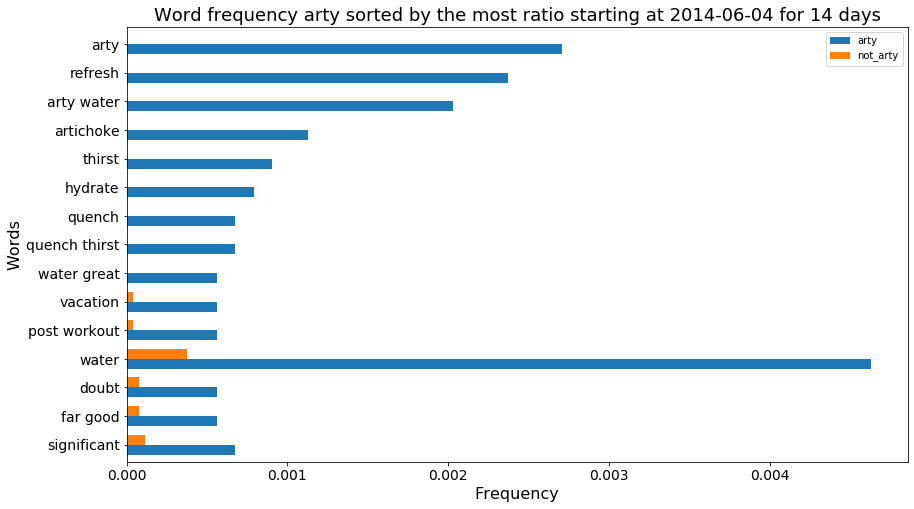

In [47]:
EVENT_DATE = pd.datetime(2014,6,4)
EVENT_DURATION = pd.Timedelta('14 days')
EVENT_COLUMNS = ['arty', 'not_arty'] 
_, event_reviews = word_freq_and_plot(unique_reviews, reviews_per_week_filled, EVENT_DATE, EVENT_DURATION, EVENT_COLUMNS, 15, end_year=2014, figsize=(14,8))

The real outliers are *arty, refresh, arty water, artichoke, thirst, hydrate, quench thirst, quench, water great* the frequency isn't that big but these words were basically never used outside of this period so it's still interesting to take a look at what this is about. Looks they are all about some water from the brand Arty, let's see what they say:

In [ ]:
event_reviews[event_reviews["reviewText"].str.contains("Arty\W")]

This is quite strange they are all about the same product as you can see with the `asin`. Let's see what the product is and what is its time series to see what all the fuss is about.

In [ ]:
meta[meta["asin"]=="B00JW3G3ZC"] # Indeed Arty water, namely 'pure natural artichoke water'

In [ ]:
plot_time_series(["B00JW3G3ZC"], "test-arty", "Arty water time series") # Its time series

Very weird indeed, this product wasn't even on Amazon prior to this event and when it came out it got a lot of reviews and then basically no one talked about it. Now could these be fake reviews?! Seems conveniant to pay a few bucks to have a good start on the website and move on from there, since first reviews are very important as we saw in class. Let's take all the reviews that are during the peak.

In [ ]:
reviews_arty = reviews[(reviews["asin"]=="B00JW3G3ZC") & (reviews["reviewTime"] <= "2014-06-29")]
reviews_arty

In [ ]:
reviews_arty.groupby('stars').size() # Almost ALL the reviews are 5 stars

In [ ]:
count = reviews_arty['reviewText'].str.contains('Arty').sum()
count/len(reviews_arty.index) # Half of them mention 'Arty'

This is quite fishy most of them explicitly mention the brand's name which is in itself a bit weird and we can for example compare to the cookies from before. In the cookies reviews they almost never mentioned the brand's name. We can easily check that:

In [134]:
# Cookies that were popular's brand
meta['brand'][meta['asin'] == id_cookie].values[0]

"David's Cookies"

In [131]:
count = reviews_cookie['reviewText'].str.contains('David').sum()
count/len(reviews_cookie.index)

0.04

We can also see that they almost only give 5 stars but this isn't conclusive evidence since most of the rating are 5 stars anyway. But we read the reviews and selected 2 that are worth showing and give a good insight about them being fake.

In [118]:
review_1 = reviews_arty['reviewText'][reviews_arty['reviewText'].str.contains("!!!!!!!!!")].values[0]
review_2 = reviews_arty['reviewText'][reviews_arty['reviewText'].str.contains("Arty is crisp and not only perfect to quench your thirst")].values[0]

pprint.pprint(review_1)
print()
pprint.pprint(review_2)

('This water is wonderful!  I rather have this instead of the other drinks '
 "I've had in the past.  It is refreshing and unlike anything I ever tried "
 'before.  I am so glad to be introduced to this product.  Way to go Arty '
 'Water Company!!!!!!!!!!!!!!  I will tell my friends about this '
 'product!!!!!!!!!!!!!!!!!!!!!')

('My first taste of Arty completely took me by surprise!  Not being a huge fan '
 "of artichokes (except for when combined with cheese and butter), I wasn't "
 'sure what to expect, but I love the refreshing, light taste.  Other fruit '
 'and vegetable based waters can have a lingering aftertaste but Arty is crisp '
 'and not only perfect to quench your thirst after a killer workout, but also '
 'to give your body so many important vitamins and minerals.  I have tried it '
 'both cold and warm/room temp and I really loved it both ways - even after a '
 'sweat session, the room temp was delish (I cannot say the same for other '
 'waters, ahem - coconut water).  

These reviews are really over the top they represent everything a fake review would be from a basic marketing point of view.
1. They mention other waters that weren't as good while being extra careful at never mentioning other brands.
2. Never talk about other brands but they mention Arty water (and not forgetting to capitalize the first letter)
3. They said they weren't convinced at first but as soon as they tried it the gates of Valhalla opened to them! :D
4. The first one says he will tell about it to all of his friends, while the second is now a transcended human being he does 'KILLER workouts' and has all the vitamins and minerals he could ever wish for.

These are all basic points a fake review would have. They are supposed to represent the buyer not being sure about whether he should buy it or not, he looks at reviews and relates to the reviewers and give it a shot.

#### Second anomaly : Kasandrinos olive oil

Let's try with the second one. If we choose as our time window two weeks at the beginning of november we get interesting results. 

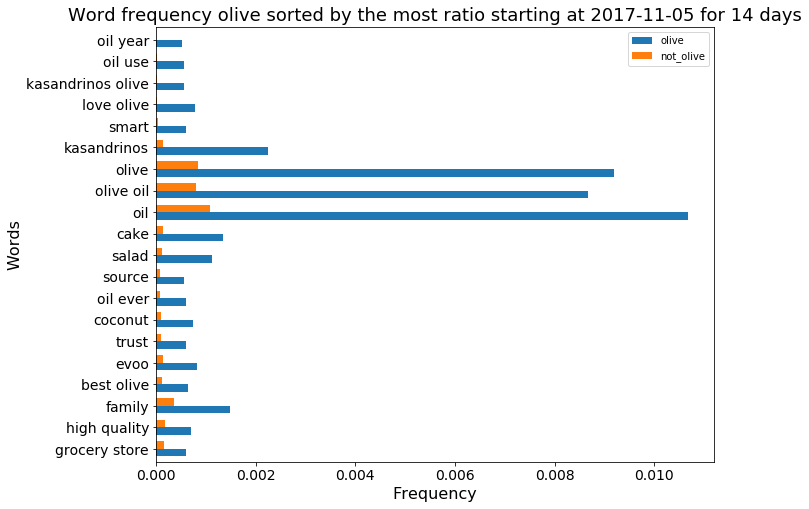

In [48]:
EVENT_DATE = pd.datetime(2017, 11, 5)
EVENT_DURATION = pd.Timedelta('14 days')
EVENT_COLUMNS = ['olive', 'not_olive'] 
_, event_reviews_olive = word_freq_and_plot(unique_reviews, reviews_per_week_filled, EVENT_DATE, EVENT_DURATION, EVENT_COLUMNS, 20, figsize=(10,8), end_year=2017)

Apparently, people are fond of olive oil, which seems a bit peculiar since it is in november (one could have argued that if it was in summer maybe that could be easily explained). So let's choose the same time window but a year before.

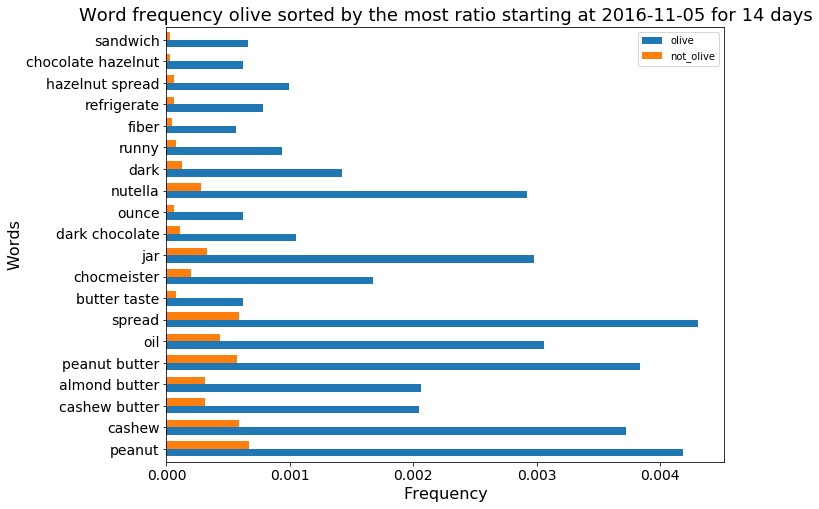

In [49]:
EVENT_DATE = pd.datetime(2016, 11, 5)
EVENT_DURATION = pd.Timedelta('14 days')
EVENT_COLUMNS = ['olive', 'not_olive'] 
_, _ = word_freq_and_plot(unique_reviews, reviews_per_week_filled, EVENT_DATE, EVENT_DURATION, EVENT_COLUMNS, 20, figsize=(10,8), end_year=2016)

Indeed, as expected olive is not as popular as it is in 2017 and it seems to concern a brand of olive oil whose name is "kasandrinos" and if we display the reviews we directly get that it basically only concerns one products whose asin is 'B01GIW8STI'. So let's plot its number of reviews over time :

In [ ]:
plot_time_series(['B01GIW8STI'], 'kasandrinos_olive')

There seems to be a huge spike in the lifetime of this product and if we look closer at the reviews we can see that some people are talking about a podcast whose name is balanced bites and whose coauthor is Diane Sanfillippo. We suspect that the Kasandrinos house paid several podcasts and websites (maybe including amazon) to advertise their product. Indeed, we notice that not only balanced bites is mentioned in the reviews, but there's also Dr. Michael Greger with Nutritionfacts.org and biophysicist Sarah Ballantyne a.k.a 'The Paleo Mom' and so forth. Moreover, 'coincidentally' the kasandrinos olive oil is on the Balanced Bites online shop. Below we show two comments concerning Balanced Bites :

In [117]:
podcast_reviews = event_reviews_olive[event_reviews_olive['reviewText'].str.contains('oil|olive|oil', case=False)\
                                     & event_reviews_olive['reviewText'].str.contains('balanced bites', case=False)].loc[:,'reviewText'].to_numpy()

for r in podcast_reviews:
    pprint.pprint(r)
    print()

('Love, love, LOVE this olive oil! Such a delicious flavor and great to cook '
 'with or add as a topping. I heard of Kasandrinos after listening to the '
 'Balanced Bites podcast and was immediately interested because of their '
 'family business and sustainability. So happy I found them... I will be a '
 'customer for life!')

('I have been listening to the Balanced Bites Podcast and following Diane San '
 'Filippo for years and never actually tried the Kasandrinos Olive Oil which '
 'she refers to, raves about and recommends as the only olive oil to use. '
 '(because its amazing) I was at a friends house last weekend and she had a '
 'bottle and I got to try it and I was in olive heaven. I tasted a teaspoon '
 'and went back for a tablespoon.  Its smooth, creamy, lemony, and rich and '
 'has the pure olive taste that Mediterranean food is known for. I cannot wait '
 'to purchase my own and give it away as Christmas gifts this holiday season, '
 'because who doesnt LOVE a good gift?'

Comments are quite funny since reviewers seem to be really in love with that olive oil. Indeed when quoting from the reviews above **"I was at a friends house last weekend and she had a bottle and I got to try it and I was in olive heaven. I tasted a teaspoon and went back for a tablespoon."**

<figure style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;">
    <img src="https://media.giphy.com/media/33E7VIA7GWuwxLpuNu/giphy.gif">
    <figcaption><em style="font-size: 20px;">Source: <a href="https://www.youtube.com/watch?v=DSRSgMp5X1w">Christina Aguilera - Accelerate</a></em></figcaption>
</figure> 

#### Christmas

Let's dive into the analysis with the first event. Our first choice falls upon Christmas and we choose our windows to be approximately the last three weeks of december from the year of 2012 until 2017

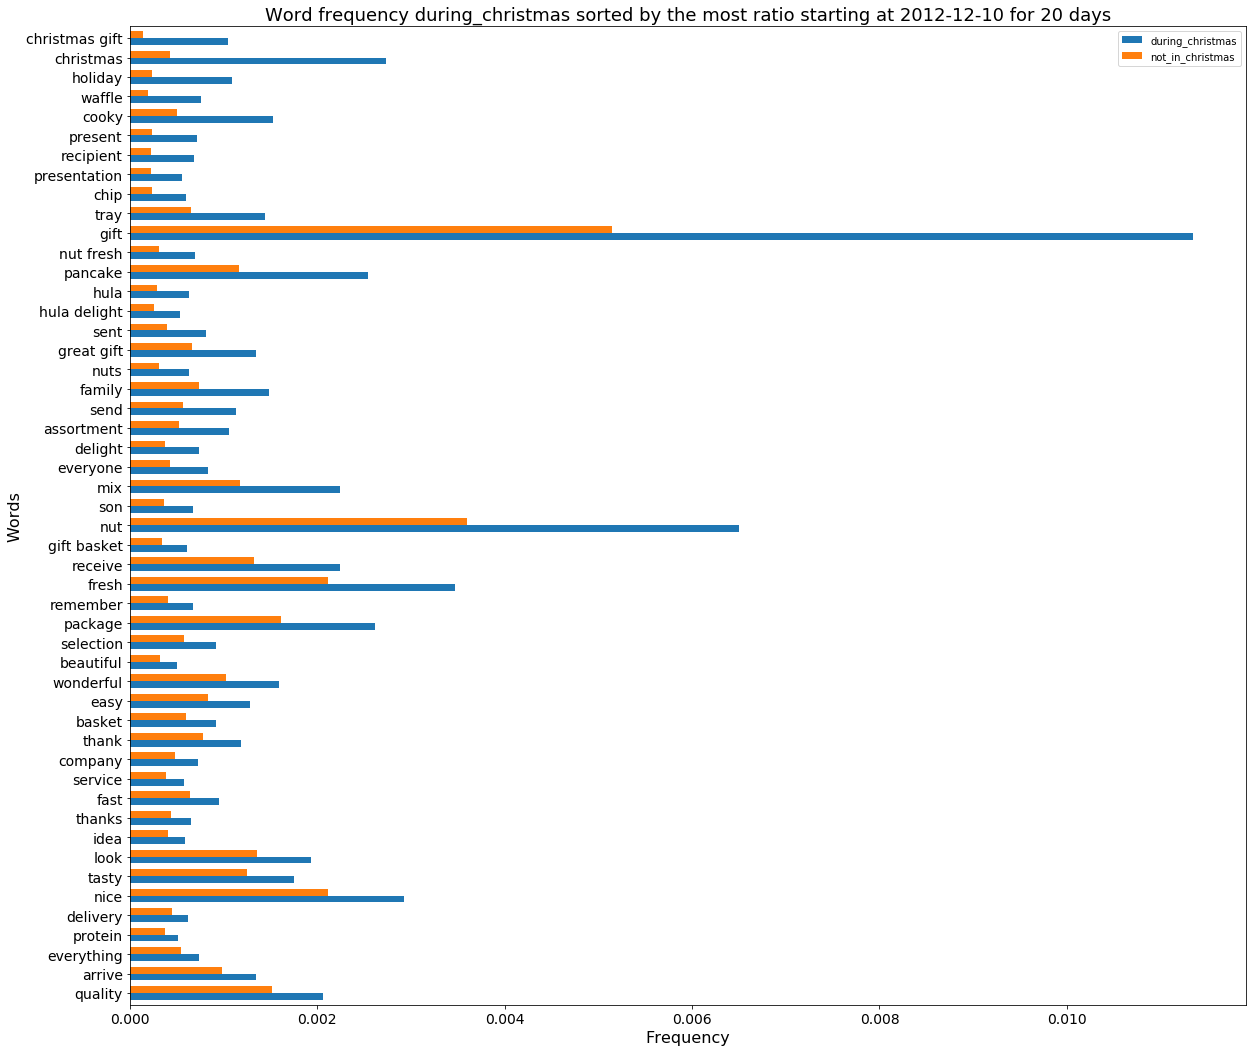

In [62]:
christmas_activity, christmas_reviews = word_freq_and_plot(unique_reviews, unique_reviews_per_week,\
                                                           CHRISTMAS_DATE, CHRISTMAS_DURATION, CHRISTMAS_COLUMNS, NUM_TOP_WORDS)

Taking the ratio between the frequencies bring conclusive results. The goal was to take a period during the year and try to see if a particular event influences the former. Here, we take the month a december and try to show how Christmas is present during it. We can try to manually extract topics from the plot:

- Christmas : "Christmas", "Holiday", "Present", "Gift", "Package"

- Family : "Family", "Son", "Brother", "Everyone", "Party"

- Food, cooking and baking : "Waffle", "Flour", "Batter", "Pancakes", "Egg", "Mix", "Cook", "Cinnamon", "Butter", "Recipient"

The three main topics extracted here are all strongly related to Christmas. However, one should be careful about the conclusions regarding those topics since the one about cooking and baking is also related to winter. 

#### Valentine's day

We can now try the same analysis on another event. Here we choose two weeks in february around the 14th of february.

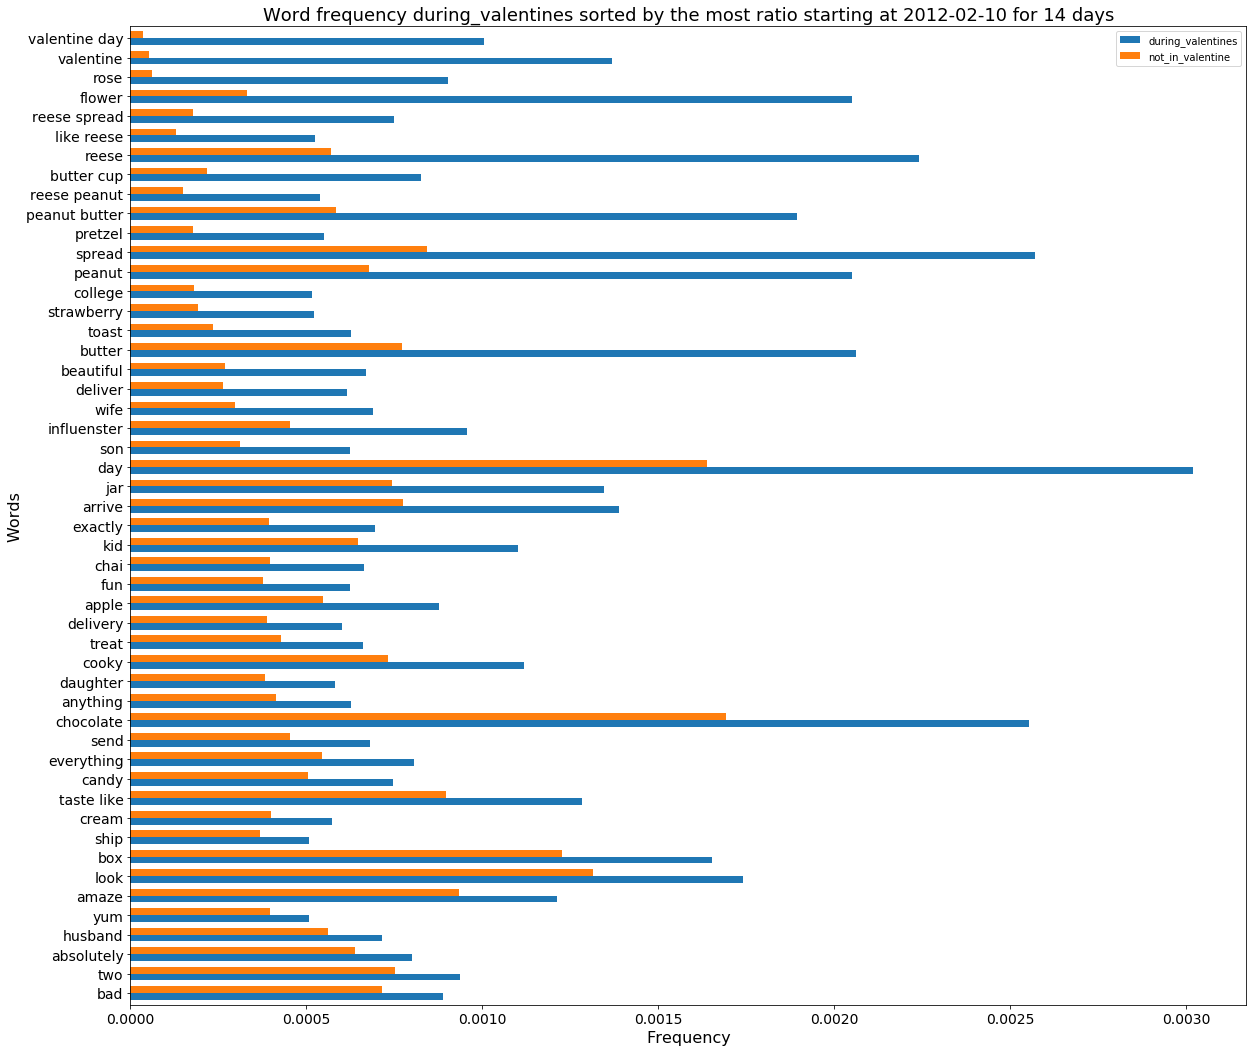

In [68]:
valentine_activity, valentine_reviews = word_freq_and_plot(unique_reviews, reviews_per_week_filled,\
                                                           VALENTINE_DATE, VALENTINE_DURATION, VALENTINE_COLUMNS, NUM_TOP_WORDS)

In [72]:
reese_valentine = valentine_reviews[valentine_reviews['reviewText'].str.contains('reese')]
asin_reese_valentine = reese_valentine['asin'].unique()
asin_reese_valentine

array(['B00S0ABRNQ'], dtype=object)

In [76]:
meta[meta['asin'] == asin_reese_valentine[0]]['title']

229708    Reese's Spreads Peanut Butter Chocolate Jar, 13oz
Name: title, dtype: object

In [94]:
kabloom_asins = meta[meta['brand'] == 'KaBloom'].loc[:,'asin'].to_numpy()
kabloom_asins_activity = pd.DataFrame(reviews[reviews['asin'].isin(kabloom_asins)].groupby(by='asin')['asin'].count().rename('count'))
kabloom_asins_activity.sort_values(by='count', ascending=False).head(30)

,count
asin,
B00J5HD588,1100
B01AMT1IY0,377
B00J5H346Q,334
B0166AQTZM,270
B01AMT15PW,170
...,...
B01AMT1NHM,1
B00J5H721O,1
B00J5HCI40,1


In [41]:
valentine_products = valentine_activity.merge(meta, on='asin')
sorted_valentine_products = valentine_products.sort_values(by='delta', ascending=False)#.head(50)

In [49]:
sorted_valentine_products[sorted_valentine_products['brand'] == "KaBloom"]

,asin,median in year,mean in period,delta,event_start_date,category,description,title,brand,rank,main_cat,price,date
15,B00J5H346Q,1.0,48.0,47.0,2017-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Roses,"A timeless, romantic classic, this bouquet of fresh cut red roses is sure to melt the heart of w...","Kabloom The Romantic Classic Bouquet of 12 Fresh Red Roses (Farm-Fresh, Long-Stem) with Vase",KaBloom,"104,902inGroceryGourmetFood(",Grocery,44.99,NaT
40,B01AMT15PW,2.0,36.0,34.0,2018-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Roses,"A timeless, romantic classic, this bouquet of fresh cut red roses is sure to melt the heart of w...","Kabloom The Romantic Classic Bouquet of 12 Fresh Red Roses (Farm-Fresh, Long-Stem) with Vase",KaBloom,"120,409inGroceryGourmetFood(",Grocery,NaN,NaT
16,B00J5HD588,6.5,19.0,12.5,2017-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Orchids,"A best seller, these unique long-lasting, sapphire blue-tinted fresh cut dendrobium orchids are ...",Kabloom Exotic Sapphire Orchid Bouquet of Blue Orchids from Thailand with Vase,KaBloom,"6,268inGroceryGourmetFood(",Grocery,36.30,NaT
41,B01AMT193U,2.0,14.0,12.0,2018-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Roses,"Send a sweet surprise with this beautiful bouquet full of charming, fragrant pink roses that are...","Kabloom Bouquet of 12 Fresh Pink Roses (Farm-Fresh, Long-Stem) with Vase",KaBloom,"45,099inGroceryGourmetFood(",Grocery,39.99,NaT


In [109]:
meta[meta['asin'] == 'B01AMT1IY0']

,category,description,title,brand,rank,main_cat,price,asin,date
270506,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Orchids,"A best seller, these unique long-lasting, Blue and White dendrobium orchids remind us of those s...",Kabloom Starry Night in the Tropics Bouquet of Blue and White Orchids from Thailand with Vase,KaBloom,"2,656inGroceryGourmetFood(",Grocery,NaN,B01AMT1IY0,NaT


In [40]:
valentine_products['brand']

0            David's Cookies
1            David's Cookies
2            David's Cookies
3            David's Cookies
4                      Bragg
5            Prince Of Peace
6                We Got Nuts
7         Golden State Fruit
8         Golden State Fruit
9                     Kisses
10     Death Wish Coffee Co.
11                King David
12          Carrington Farms
13             Viva Naturals
14               We Got Nuts
15                   KaBloom
16                   KaBloom
17             Hula Delights
18          BetterBody Foods
19                  Oh! Nuts
20          Jade Leaf Matcha
21              Organic Wise
22                   nutpods
23                   nutpods
24             Viva Naturals
25             Mission Meats
26           Fusionroaster75
27           Custom Varietea
28          Jade Leaf Matcha
29    Five Star Gift Baskets
30         Greenbow Gift Box
31        Golden State Fruit
32             CANOPY SNACKS
33                   nutpods
34            

### 2.3.2 Causal impact

So far, in this section, we extracted popular products in a given time window and then extracted most popular words in the reviews of those products and compared them with the same words in the reviews of the same products but in the rest of the year. Then, we manually grouped those words into topics and concluded whether or not a given event affects the time window we chose.

Here the approach is different, instead of extracting topics we compare time series. In other words, we again consider products that are popular in the time window that we choose, the same way we did in part 2.3.1, but we compare the time serie of one of the popular product of the time window with products that are considered not particularly popular in order to predict what the former would have been if the event wouldn't have affected it

In [52]:
from causalimpact import CausalImpact

In [111]:
pd.date_range(start='2016-01-01', end='2018-03-01', freq='W')

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28', '2016-03-06',
               ...
               '2017-12-24', '2017-12-31', '2018-01-07', '2018-01-14',
               '2018-01-21', '2018-01-28', '2018-02-04', '2018-02-11',
               '2018-02-18', '2018-02-25'],
              dtype='datetime64[ns]', length=113, freq='W-SUN')

In [53]:
def create_time_series(reviews_weeks_df, asins_to_sample):
    """
    Randomly sample nb_products_to_sample products in reviews_weeks_df for a given year
    """
    # iterate to create a dataframe with each column containing the time series of a product
    asins_time_series = pd.DataFrame()
    for a in asins_to_sample: 
        product = reviews_weeks_df.loc[(reviews_weeks_df.asin == a)]
        asins_time_series[a] = product['reviewCount'].to_numpy()
    return asins_time_series

In [136]:
def plot_causal_impact(event_product_asin, non_event_product_asins, reviews_per_week, event_start_date, event_duration, end_event_last_year, debug=False, verbose=True):
    # Filter reviews_per_week for concerned period i.e a whole year starting from the end of the year
    # from last year and the end of the event for the current year
    period_1 = end_event_last_year
    period_2 = event_start_date - pd.Timedelta('7d')
    period_3 = event_start_date
    period_4 = period_1 + pd.Timedelta('1y')
    reviews_per_week_year = reviews_per_week[(reviews_per_week['reviewTime'] >= period_1) & (reviews_per_week['reviewTime'] <= period_4)]
    
    # Extract time series of concerned asins
    time_series = create_time_series(reviews_per_week_year, event_product_asin + non_event_product_asins)
    time_series.set_index(pd.date_range(start=period_1, end=period_4, freq='W'), inplace=True)
    time_series.index = time_series.index.map(lambda date: pd.Timestamp(date.date()))
    time_series = time_series[event_product_asin + non_event_product_asins]
    if debug:
        display(time_series)
        print(period_1, period_2, period_3, period_4)
    
    # Predict and plot causalimpact
    period_4 = time_series.index[-1]
    pre_period = [pd.Timestamp(period_1.date()), pd.Timestamp(period_2.date())]
    post_period = [pd.Timestamp(period_3.date()), pd.Timestamp(period_4.date())]
    ci = CausalImpact(time_series, pre_period, post_period)
    ci.plot()
    if verbose:
        print(ci.trained_model.params)
        print(ci.summary())


In [143]:
VALENTINE_DATE_CI = pd.datetime(2017, 2, 12)
VALENTINE_END_LAST_YEAR = pd.datetime(2016, 2, 21)
VALENTINE_DURATION_CI = pd.Timedelta('14 days')
NOT_INFLUENCED_ASINS_V = ["B00KSN9TME", "B000U0OUP6", "B000E1FZHS", "B0010SEVWO", "B00K5R4ZWM"]
INFLUENCED_ASIN_V = ['B00J5H346Q']

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


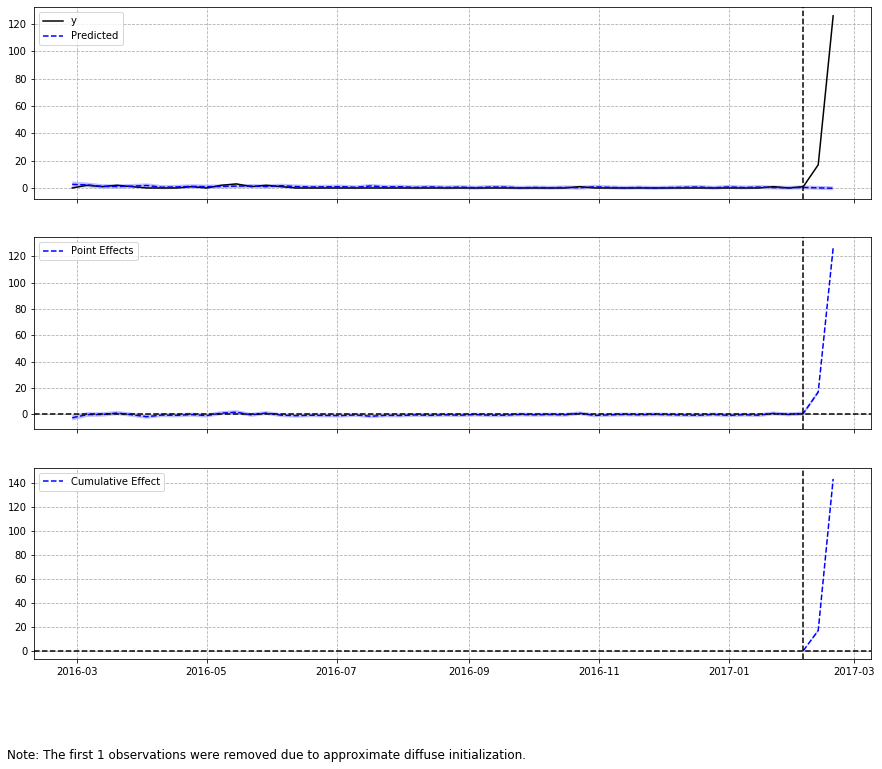

sigma2.irregular    0.863229
sigma2.level        0.000144
beta.B00KSN9TME     0.156573
beta.B000U0OUP6     3.247632
beta.B000E1FZHS    -2.973360
beta.B0010SEVWO    -0.098384
beta.B00K5R4ZWM    -0.076028
dtype: float64
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    71.5               143.0
Prediction (s.d.)         -0.04 (0.53)       -0.07 (1.07)
95% CI                    [-1.14, 0.95]      [-2.29, 1.9]

Absolute effect (s.d.)    71.54 (0.53)       143.07 (1.07)
95% CI                    [70.55, 72.64]     [141.1, 145.29]

Relative effect (s.d.)    -191070.62% (1428.12%)-191070.62% (1428.12%)
95% CI                    [-194026.08%, -188427.96%][-194026.08%, -188427.96%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [144]:
plot_causal_impact(INFLUENCED_ASIN_V, NOT_INFLUENCED_ASINS_V, reviews_per_week_filled, VALENTINE_DATE_CI, VALENTINE_DURATION_CI, VALENTINE_END_LAST_YEAR)

In [139]:
CHRISTMAS_DATE_CI = pd.datetime(2016, 12, 4)
CHRISTMAS_END_LAST_YEAR = pd.datetime(2016, 1, 3)
CHRISTMAS_DURATION_CI = pd.Timedelta('30 days')
NOT_INFLUENCED_ASINS_C = ["B00KSN9TME", "B000U0OUP6", "B000E1FZHS", "B0010SEVWO", "B00K5R4ZWM"]
INFLUENCED_ASIN_C = ['B00KCCKV8W']

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


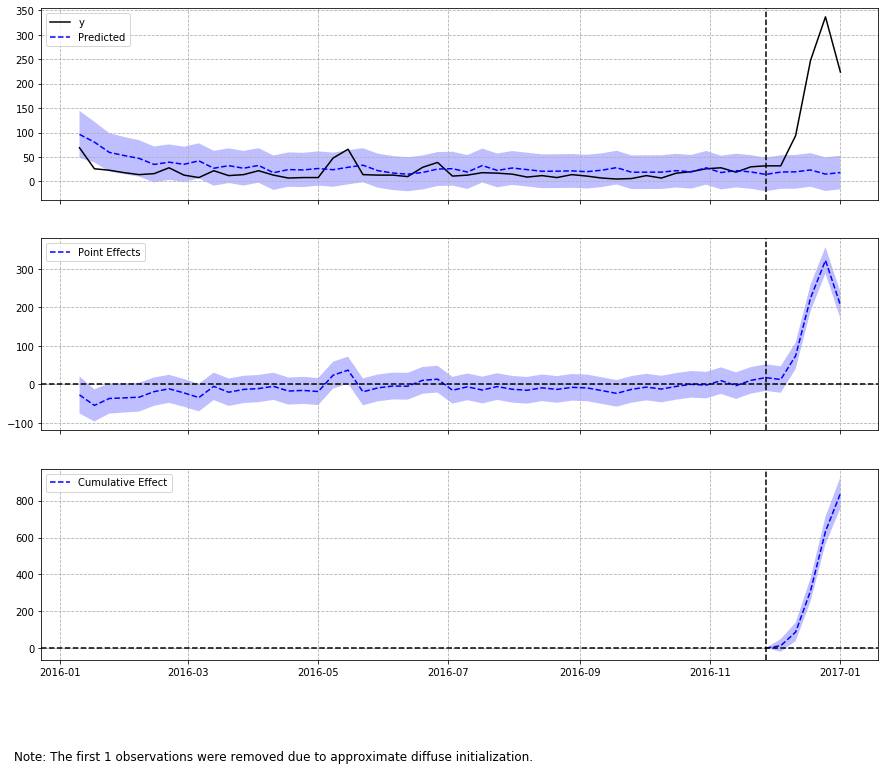

sigma2.irregular    0.957702
sigma2.level        0.000144
beta.B00KSN9TME     0.136893
beta.B000U0OUP6    -0.153263
beta.B000E1FZHS     0.262309
beta.B0010SEVWO     0.022350
beta.B00K5R4ZWM    -0.180395
dtype: float64
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    187.0              935.0
Prediction (s.d.)         19.19 (8.62)       95.96 (43.08)
95% CI                    [1.57, 35.35]      [7.86, 176.73]

Absolute effect (s.d.)    167.81 (8.62)      839.04 (43.08)
95% CI                    [151.65, 185.43]   [758.27, 927.14]

Relative effect (s.d.)    874.38% (44.89%)   874.38% (44.89%)
95% CI                    [790.21%, 966.19%] [790.21%, 966.19%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [140]:
plot_causal_impact(INFLUENCED_ASIN_C, NOT_INFLUENCED_ASINS_C, reviews_per_week_filled, CHRISTMAS_DATE_CI, CHRISTMAS_DURATION_CI, CHRISTMAS_END_LAST_YEAR)

Get most active product in christmas